# Extend the Best 6M Model with Competitor Data

* Best model for 6M prediction: 17 features selected by SHAP + Boruta(Wrapper Method) + 4 lag Features
* RMSE = 0.000447, MAE = 0.000385, MAPE = 0.155794

In [1]:
import pandas as pd
import numpy as np
import csv
import seaborn as sns
from time import strptime

import matplotlib.pyplot as plt

import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from xgboost import plot_importance, plot_tree
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from BorutaShap import BorutaShap
import missingno as msno

#!pip install shap
import shap
shap.initjs()

(144, 97)
(144, 98)


<AxesSubplot:>

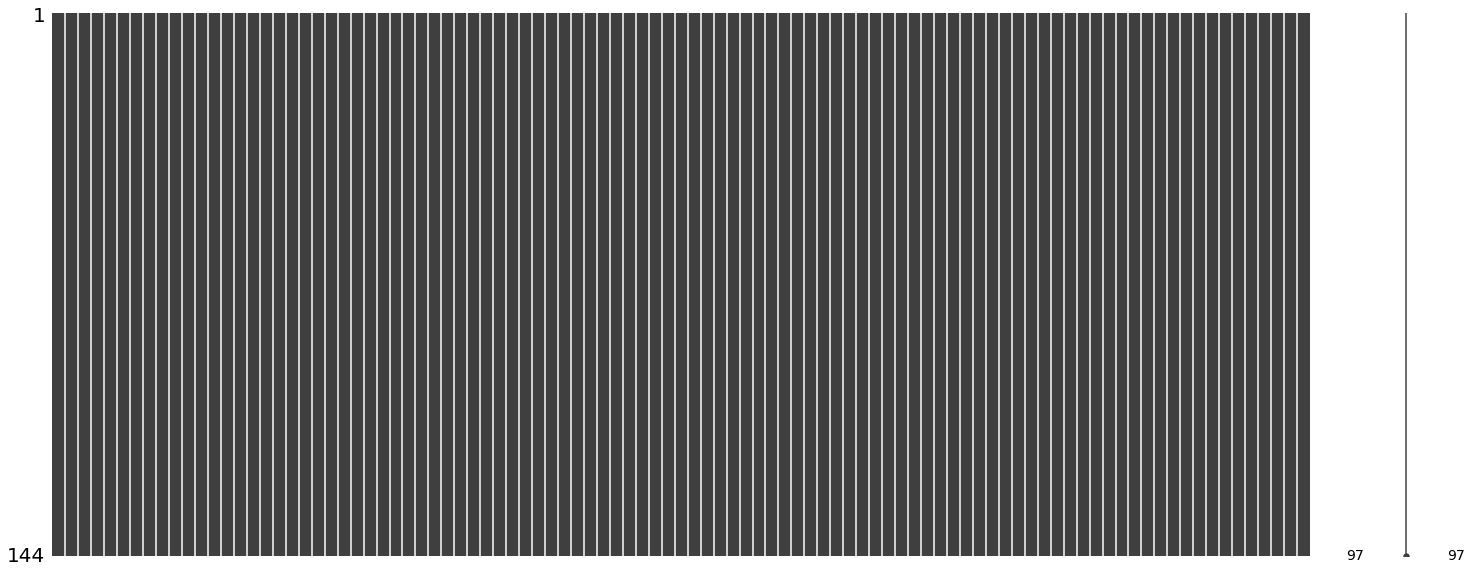

In [2]:
# load data
competitor_data = pd.read_csv("./data/08-19_v2.csv", index_col = [0])
competitor_data1 = pd.read_csv("./data/08-19_v2.csv")

competitor_data.index = pd.to_datetime(competitor_data.index)
competitor_data1["month"] = pd.to_datetime(competitor_data1["month"])

print(competitor_data.shape)
print(competitor_data1.shape)

msno.matrix(competitor_data)

## Feature Engeneering

In [3]:
def lag_feature(df, lags, new_df_col, target_col):
    tmp = df[new_df_col]
    for i in lags:
        tmp[target_col+'_lag_'+str(i)] = df[target_col].shift(i)
    
    tmp[target_col] = df[target_col]
    return tmp

def fill_na(df):
    for col in df.columns:
        if ('_lag_' in col) & (df[col].isnull().any()):
            df[col].fillna(0, inplace=True)         
    return df

### Check Column Type

In [4]:
competitor_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 144 entries, 2008-01-01 to 2019-12-01
Data columns (total 97 columns):
 #   Column                                                                                    Non-Null Count  Dtype  
---  ------                                                                                    --------------  -----  
 0   aus_population_natural_increase                                                           144 non-null    float64
 1   aus_population_overseas_arrivals                                                          144 non-null    float64
 2   aus_population_net overseas migration                                                     144 non-null    float64
 3   aus_population_estimated resident population                                              144 non-null    float64
 4   aus_beef&veal_slaughterings                                                               144 non-null    float64
 5   aus_beef&veal_average weight          

## Modeling
### Train/ Test Preparation: cut off the data after 2019.6 to use as our test set.

<AxesSubplot:>

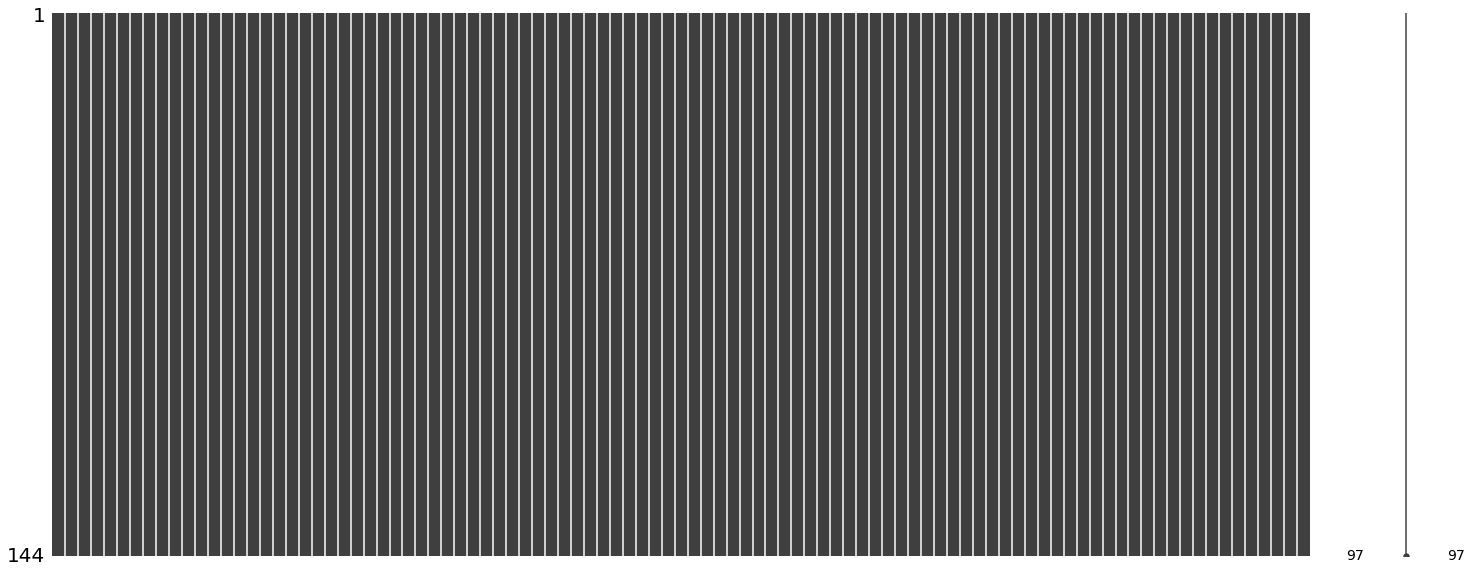

In [5]:
msno.matrix(competitor_data)

In [9]:
xgb_Test_Accuracy_Data = pd.DataFrame(columns = ['feature','n_estimators','max_depth','min_child_weight',
                                                 'gamma','learning_rate','subsample','colsample_bytree',
                                                 'eta','RMSE','MAE', 'MAPE'])

In [10]:
# split data for selected features

selected_features_shap_17 = ['us_livestock_commercial_lambs and yearlings', 'aus_beef&veal_exports', 
                            'us_livestock_commercial_beef', 'aus_total dairy cattle and calves', 
                            'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)', 
                            'us_veganism', 'aus_avg_rainfall', 'us_veganism_trend_ratio', 
                            'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Seasonally adjusted (tonnes)', 
                            'us cattle numbers(*1000)', 'us_fed_avg_dressed_calves',
                            'aus_exports of beef, veal and live cattle to US',
                             'us_production_fedral_inspected_total poultry', 'us_cold_storage_beef', 
                             'us_production_commercial_beef', 'us_livestock_commercial_mature sheep', 
                             'us_livestock_commercial_steers',
                            'import_ratio']

selected_features_shap_month_17 = ['month','us_livestock_commercial_lambs and yearlings', 'aus_beef&veal_exports', 
                            'us_livestock_commercial_beef', 'aus_total dairy cattle and calves', 
                            'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)', 
                            'us_veganism', 'aus_avg_rainfall', 'us_veganism_trend_ratio', 
                            'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Seasonally adjusted (tonnes)', 
                            'us cattle numbers(*1000)', 'us_fed_avg_dressed_calves',
                            'aus_exports of beef, veal and live cattle to US',
                            'us_production_fedral_inspected_total poultry', 'us_cold_storage_beef', 
                            'us_production_commercial_beef', 'us_livestock_commercial_mature sheep', 
                            'us_livestock_commercial_steers',
                            'import_ratio']

aus_us_ca_nz_features = ['us_livestock_commercial_lambs and yearlings', 'aus_beef&veal_exports', 
                         'us_livestock_commercial_beef', 'aus_total dairy cattle and calves',
                         'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)',
                         'us_veganism', 'aus_avg_rainfall', 'us_veganism_trend_ratio',
                         'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Seasonally adjusted (tonnes)',
                         'us cattle numbers(*1000)', 'us_fed_avg_dressed_calves',
                         'aus_exports of beef, veal and live cattle to US',
                         'us_production_fedral_inspected_total poultry', 'us_cold_storage_beef',
                         'us_production_commercial_beef', 'us_livestock_commercial_mature sheep',
                         'us_livestock_commercial_steers',
                         'ca_beef_export_total', 'ca_beef_veal_prod',
                         'ca_avg_rainfall', 'ca_beef_export_us', 
                         'nz_beef_export_total','nz_beef_veal_prod',      
                         'nz_avg_rainfall', 'nz_beef_export_us','import_ratio']



aus_us_ca_nz_features_month = ['month','us_livestock_commercial_lambs and yearlings', 'aus_beef&veal_exports', 
                         'us_livestock_commercial_beef', 'aus_total dairy cattle and calves',
                         'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)',
                         'us_veganism', 'aus_avg_rainfall', 'us_veganism_trend_ratio',
                         'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Seasonally adjusted (tonnes)',
                         'us cattle numbers(*1000)', 'us_fed_avg_dressed_calves',
                         'aus_exports of beef, veal and live cattle to US',
                         'us_production_fedral_inspected_total poultry', 'us_cold_storage_beef',
                         'us_production_commercial_beef', 'us_livestock_commercial_mature sheep',
                         'us_livestock_commercial_steers',
                         'ca_beef_export_total', 'ca_beef_veal_prod',
                         'ca_avg_rainfall', 'ca_beef_export_us', 
                         'nz_beef_export_total','nz_beef_veal_prod',      
                         'nz_avg_rainfall', 'nz_beef_export_us', 'import_ratio']


selected_df = competitor_data[aus_us_ca_nz_features]
idx = selected_df.shape[1]-1
selected_test_df = selected_df.iloc[138:144,:]
selected_train_df = selected_df.iloc[:138,:]

selected_X_train, selected_y_train = selected_train_df.iloc[:,:idx], selected_train_df.iloc[:,idx]
selected_X_test, selected_y_test = selected_test_df.iloc[:,:idx], selected_test_df.iloc[:,idx]

# has month: combine_data1
selected_df1 = competitor_data1[aus_us_ca_nz_features_month]
idx1 = selected_df1.shape[1]-1
selected_test_df1 = selected_df1.iloc[138:144,:]
selected_train_df1 = selected_df1.iloc[:138,:]

selected_X_train1, selected_y_train1 = selected_train_df1.iloc[:,:idx1], selected_train_df1.iloc[:,idx1]
selected_X_test1, selected_y_test1 = selected_test_df1.iloc[:,:idx1], selected_test_df1.iloc[:,idx1]
selected_X_test1


month  us_livestock_commercial_lambs and yearlings  \
138 2019-07-01                                       177.00   
139 2019-08-01                                       189.99   
140 2019-09-01                                       168.29   
141 2019-10-01                                       194.66   
142 2019-11-01                                       169.84   
143 2019-12-01                                       184.79   

     aus_beef&veal_exports  us_livestock_commercial_beef  \
138                  155.1                        266.56   
139                  155.1                        265.32   
140                  155.1                        258.27   
141                  155.1                        313.33   
142                  155.1                        298.08   
143                  155.1                        287.52   

     aus_total dairy cattle and calves  \
138                               2341   
139                               2341   
140                               2341   
141                               2341   
142                               2341   
143                               2341   

     aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)  \
138                                             217211                               
139                                             208482                               
140                                             203968                               
141                                             218145                               
142                                             218822                               
143                                             171517                               

     us_veganism  aus_avg_rainfall  us_veganism_trend_ratio  \
138           74              10.5                     0.58   
139           80               8.6                     0.59   
140           75               6.8                     0.57   
141           80               8.3                     0.56   
142          100              11.9                     0.61   
143           96              15.4                     0.58   

     aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Seasonally adjusted (tonnes)  \
138                                             198966                                          
139                                             198564                                          
140                                             204823                                          
141                                             208080                                          
142                                             209563                                          
143                                             203349                                          

     ...  us_livestock_commercial_mature sheep  \
138  ...                                 11.60   
139  ...                                 12.91   
140  ...                                 11.01   
141  ...                                 11.34   
142  ...                                 11.16   
143  ...                                 11.71   

     us_livestock_commercial_steers  ca_beef_export_total  ca_beef_veal_prod  \
138                         1511.93             44.939167         111.833333   
139                         1461.99             44.939167         111.833333   
140                         1277.93             44.939167         111.833333   
141                         1392.84             44.939167         111.833333   
142                         1332.98             44.939167         111.833333   
143                         1309.32             44.939167         111.833333   

     ca_avg_rainfall  ca_beef_export_us  nz_beef_export_total  \
138          58.1391       71346.148298                38.094   
139          58.9165       78710.596148                28.119   
140          49.432

In [154]:
len(aus_us_ca_nz_features)

26

In [102]:
# using shap+boruta to check the feature selection result
model_BorutaShap_model = XGBRegressor()

# if classification is False it is a Regression problem
Feature_Selector = BorutaShap(model=model_BorutaShap_model,
                              importance_measure='shap',
                              classification=False)

#Feature_Selector.fit(X=X_train, y=y_train, n_trials=100, sample=False,
#                     train_or_test = 'test', verbose=True, random_state = 517)

Feature_Selector.fit(X=selected_X_train, y=selected_y_train, n_trials=100, verbose=True, random_state = 517)

  0%|          | 0/100 [00:00<?, ?it/s]

8 attributes confirmed important: ['nz_avg_rainfall', 'aus_beef&veal_exports', 'us_fed_avg_dressed_calves', 'us_veganism_trend_ratio', 'ca_avg_rainfall', 'aus_exports of beef, veal and live cattle to US', 'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Seasonally adjusted (tonnes)', 'us_veganism']
15 attributes confirmed unimportant: ['ca_beef_export_us', 'nz_meat_prod', 'us_production_fedral_inspected_total poultry', 'us_livestock_commercial_steers', 'us_livestock_commercial_lambs and yearlings', 'ca_beef_export_total', 'nz_beef_export_us', 'ca_beef_veal_prod', 'aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)', 'us_livestock_commercial_beef', 'nz_beef_veal_prod', 'ca_dairy_cattle_calf', 'nz_dairy_cattle_calf', 'us cattle numbers(*1000)', 'ca_meat_prod']
6 tentative attributes remains: ['aus_avg_rainfall', 'us_livestock_commercial_mature sheep', 'us_cold_storage_beef', 'nz_beef_export_total', 'aus_total dairy cattle and calves', 'us_production

## Modeling using selected features

In [11]:
feature = 'US_AU_CA_NZ_nomeat_nodia'

## Parameter Setting

# Number of trees
n_estimators = 908

# Maximum number of levels in tree
max_depth = 15

#minimum sum of weights of all observations required in a child
min_child_weight = 6

#Gamma specifies the minimum loss reduction required to make a split
gamma = 0

# boosting learning rate
learning_rate = 0.6314545852104018
subsample = 0.7144492016775968 # 80% of data to grow trees and prevent overfitting
colsample_bytree = 0.6094855026290542  # 85% of features used
eta = 0.1
seed = 517  # for reproducible results


xgb_reg = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth = max_depth, min_child_weight = min_child_weight,
                       gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
                       eta = eta, seed = seed, n_jobs=-1)

#Fit the regressor to the training set
#model_shap_sel_yes= xgb_reg.fit(selected_X_train, selected_y_train)

evaluation = [(selected_X_train, selected_y_train), (selected_X_test, selected_y_test)]
model_shap_sel_yes = xgb_reg.fit(selected_X_train, selected_y_train,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)


# Train Data
# Use the forest's predict method on the train data
predictions_train = xgb_reg.predict(selected_X_train)

# Calculate the absolute errors
errors_train = abs(predictions_train - selected_y_train)

# Calculate mean absolute percentage error (MAPE)
mape_train = 100 * (errors_train/ selected_y_train)
            
# Calculate and display accuracy
accuracy_train = 100 - np.mean(mape_train)

# Test Data
# Use the forest's predict method on the test data
predictions_test = xgb_reg.predict(selected_X_test)

# Calculate the absolute errors
errors_test = abs(predictions_test - selected_y_test)

# Calculate mean absolute percentage error (MAPE)
mape_test = 100 * (errors_test/ selected_y_test)

# Calculate and display accuracy
accuracy_test = 100 - np.mean(mape_test)


xgb_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['feature','n_estimators','max_depth',
                                                                      'min_child_weight','gamma',
                                                                      'learning_rate','subsample',
                                                                      'colsample_bytree','eta',
                                                                      'RMSE','MAE','MAPE'])

xgb_Test_Accuracy_Data_One.loc[:,'feature'] = feature
xgb_Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
xgb_Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
xgb_Test_Accuracy_Data_One.loc[:,'min_child_weight'] = min_child_weight            
xgb_Test_Accuracy_Data_One.loc[:,'gamma'] = gamma
xgb_Test_Accuracy_Data_One.loc[:,'learning_rate'] = learning_rate
xgb_Test_Accuracy_Data_One.loc[:,'subsample'] = subsample       
xgb_Test_Accuracy_Data_One.loc[:,'colsample_bytree'] = colsample_bytree
xgb_Test_Accuracy_Data_One.loc[:,'eta'] = eta
#xgb_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
#xgb_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test

# make predictions on the test set

predictions = xgb_reg.predict(selected_X_test)

selected_test_df['predictions'] = predictions
selected_test_df1['predictions'] = predictions

# compute the root mean sqaured error
rmse = np.sqrt(mean_squared_error(selected_y_test, predictions))

xgb_Test_Accuracy_Data_One.loc[:,'RMSE'] = rmse

mae = mean_absolute_error(selected_y_test, predictions)
xgb_Test_Accuracy_Data_One.loc[:,'MAE'] = mae

xgb_Test_Accuracy_Data_One.loc[:,'MAPE'] = np.mean(mape_test)

xgb_Test_Accuracy_Data = xgb_Test_Accuracy_Data.append(xgb_Test_Accuracy_Data_One)

xgb_Test_Accuracy_Data

feature n_estimators max_depth min_child_weight gamma  \
0  US_AU_CA_NZ_nomeat_nodia          908        15                6     0   

   learning_rate  subsample  colsample_bytree  eta      RMSE       MAE  \
0       0.631455   0.714449          0.609486  0.1  0.033145  0.028343   

        MAPE  
0  11.393058

In [14]:
# create lag features for the best subset
lag_list = [1,13]

df = selected_df
new_df_col = df.columns[:-1]
target_col = 'import_ratio'

best_lag = lag_feature(df, lag_list, new_df_col, target_col)

best_lag = fill_na(best_lag)
best_lag



df1 = selected_df1
new_df_col1 = ['month']
tmp_name = df.columns[:-1]
for i in range(len(tmp_name)):
    new_df_col1.append(tmp_name[i])

target_col1 = 'import_ratio'

best_lag1 = lag_feature(df1, lag_list, new_df_col1, target_col1)
best_lag1 = fill_na(best_lag1)
best_lag1

## best feature with lag features

# no month: 
stop_idx = best_lag.shape[1]-1

best_test_df_lag = best_lag.iloc[138:144,:]
best_train_df_lag = best_lag.iloc[:138,:]
best_X_train_lag, best_y_train_lag = best_train_df_lag.iloc[:,:stop_idx], best_train_df_lag.iloc[:,stop_idx]
best_X_test_lag, best_y_test_lag = best_test_df_lag.iloc[:,:stop_idx], best_test_df_lag.iloc[:,stop_idx]
# 3lags = 9

# has month: 
stop_idx1 = best_lag1.shape[1]-1

best_test_df1_lag = best_lag1.iloc[138:144,:]
best_train_df1_lag = best_lag1.iloc[:138,:]
best_X_train1_lag, best_y_train1_lag = best_train_df1_lag.iloc[:,:stop_idx1], best_train_df1_lag.iloc[:,stop_idx1]
best_X_test1_lag, best_y_test1_lag = best_test_df1_lag.iloc[:,:stop_idx1], best_test_df1_lag.iloc[:,stop_idx1]
# 3lags = 10

best_X_test_lag

us_livestock_commercial_lambs and yearlings  \
month                                                     
2019-07-01                                       177.00   
2019-08-01                                       189.99   
2019-09-01                                       168.29   
2019-10-01                                       194.66   
2019-11-01                                       169.84   
2019-12-01                                       184.79   

            aus_beef&veal_exports  us_livestock_commercial_beef  \
month                                                             
2019-07-01                  155.1                        266.56   
2019-08-01                  155.1                        265.32   
2019-09-01                  155.1                        258.27   
2019-10-01                  155.1                        313.33   
2019-11-01                  155.1                        298.08   
2019-12-01                  155.1                        287.52   

            aus_total dairy cattle and calves  \
month                                           
2019-07-01                               2341   
2019-08-01                               2341   
2019-09-01                               2341   
2019-10-01                               2341   
2019-11-01                               2341   
2019-12-01                               2341   

            aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)  \
month                                                                                       
2019-07-01                                             217211                               
2019-08-01                                             208482                               
2019-09-01                                             203968                               
2019-10-01                                             218145                               
2019-11-01                                             218822                               
2019-12-01                                             171517                               

            us_veganism  aus_avg_rainfall  us_veganism_trend_ratio  \
month                                                                
2019-07-01           74              10.5                     0.58   
2019-08-01           80               8.6                     0.59   
2019-09-01           75               6.8                     0.57   
2019-10-01           80               8.3                     0.56   
2019-11-01          100              11.9                     0.61   
2019-12-01           96              15.4                     0.58   

            aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Seasonally adjusted (tonnes)  \
month                                                                                                  
2019-07-01                                             198966                                          
2019-08-01                                             198564                                          
2019-09-01                                             204823                                          
2019-10-01                                             208080                                          
2019-11-01                                             209563                                          
2019-12-01                                             203349                                          

            us cattle numbers(*1000)  ...  ca_beef_export_total  \
month                                 ...                         
2019-07-01                       7.9  ...             44.939167   
2019-08-01                       7.9  ...             44.939167   
2019-09-01                       7.9  ...             44.939167   
2019-10-01                       7.9  ...             44.939167   
2019-11-01                       7.9  ...             44.939167   
2

In [13]:
feature = 'US_AU_CA_NZ_LAG_nomeat_nodia'

## Parameter Setting

# Number of trees
n_estimators = 2112

# Maximum number of levels in tree
max_depth = 13

#minimum sum of weights of all observations required in a child
min_child_weight = 7

#Gamma specifies the minimum loss reduction required to make a split
gamma = 0

# boosting learning rate
learning_rate = 0.4695571815722602
subsample = 0.5335128691103476 # 80% of data to grow trees and prevent overfitting
colsample_bytree = 0.8642097637461512  # 85% of features used
eta = 0.1
seed = 517  # for reproducible results

xgb_reg = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth = max_depth, min_child_weight = min_child_weight,
                       gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
                       eta = eta, seed = seed)

#Fit the regressor to the training set
#best_model= xgb_reg.fit(X_train_lag, y_train_lag)

evaluation = [(best_X_train_lag, best_y_train_lag), (best_X_test_lag, best_y_test_lag)]
best_model = xgb_reg.fit(best_X_train_lag, best_y_train_lag,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)


# Train Data
# Use the forest's predict method on the train data
predictions_train = xgb_reg.predict(best_X_train_lag)

# Calculate the absolute errors
errors_train = abs(predictions_train - best_y_train_lag)

# Calculate mean absolute percentage error (MAPE)
mape_train = 100 * (errors_train/ best_y_train_lag)
            
# Calculate and display accuracy
accuracy_train = 100 - np.mean(mape_train)

# Test Data
# Use the forest's predict method on the test data
predictions_test = xgb_reg.predict(best_X_test_lag)

# Calculate the absolute errors
errors_test = abs(predictions_test - best_y_test_lag)

# Calculate mean absolute percentage error (MAPE)
mape_test = 100 * (errors_test/ best_y_test_lag)

# Calculate and display accuracy
accuracy_test = 100 - np.mean(mape_test)


xgb_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['feature','n_estimators','max_depth',
                                                                      'min_child_weight','gamma',
                                                                      'learning_rate','subsample',
                                                                      'colsample_bytree','eta',
                                                                      'RMSE','MAE','MAPE'])

xgb_Test_Accuracy_Data_One.loc[:,'feature'] = feature
xgb_Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
xgb_Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
xgb_Test_Accuracy_Data_One.loc[:,'min_child_weight'] = min_child_weight            
xgb_Test_Accuracy_Data_One.loc[:,'gamma'] = gamma
xgb_Test_Accuracy_Data_One.loc[:,'learning_rate'] = learning_rate
xgb_Test_Accuracy_Data_One.loc[:,'subsample'] = subsample       
xgb_Test_Accuracy_Data_One.loc[:,'colsample_bytree'] = colsample_bytree
xgb_Test_Accuracy_Data_One.loc[:,'eta'] = eta                                                                    
#xgb_Test_Accuracy_Data_One.loc[:,'Train Accurcay'] = accuracy_train
#xgb_Test_Accuracy_Data_One.loc[:,'Test Accurcay'] = accuracy_test

# make predictions on the test set

predictions = xgb_reg.predict(best_X_test_lag)

best_test_df_lag['predictions'] = predictions
best_test_df1_lag['predictions'] = predictions

# compute the root mean sqaured error
rmse = np.sqrt(mean_squared_error(best_y_test_lag, predictions))

xgb_Test_Accuracy_Data_One.loc[:,'RMSE'] = rmse

mae = mean_absolute_error(best_y_test_lag, predictions)
xgb_Test_Accuracy_Data_One.loc[:,'MAE'] = mae
xgb_Test_Accuracy_Data_One.loc[:,'MAPE'] = np.mean(mape_test)

xgb_Test_Accuracy_Data = xgb_Test_Accuracy_Data.append(xgb_Test_Accuracy_Data_One)
   
xgb_Test_Accuracy_Data

feature n_estimators max_depth min_child_weight gamma  \
0      US_AU_CA_NZ_nomeat_nodia          908        15                6     0   
0  US_AU_CA_NZ_LAG_nomeat_nodia         2112        13                7     0   

   learning_rate  subsample  colsample_bytree  eta      RMSE       MAE  \
0       0.631455   0.714449          0.609486  0.1  0.033145  0.028343   
0       0.469557   0.533513          0.864210  0.1  0.007860  0.005818   

        MAPE  
0  11.393058  
0   2.329227

In [15]:
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe


# Initialize domain space for range of values
space={'max_depth': hp.quniform("max_depth", 10, 15, 1),
        'colsample_bytree' : hp.uniform('colsample_bytree', 0.5, 1),
        'min_child_weight' : hp.quniform('min_child_weight', 0, 10, 1),
        'n_estimators': hp.quniform ('n_estimators', 200, 3000, 1),
       'learning_rate': hp.uniform ('learning_rate', 0.01, 0.8),
       'subsample': hp.uniform ('subsample', 0.2,0.8),
        'seed': 517}

# Define objective function 
def objective(space):
    xgb_reg=xgb.XGBRegressor(n_estimators =int(space['n_estimators']), max_depth = int(space['max_depth']),
                             gamma = 0,
                             min_child_weight=space['min_child_weight'],
                             colsample_bytree=space['colsample_bytree'], 
                             learning_rate=space['learning_rate'],subsample=space['subsample'],
                             eta=0.1, seed = 517)
    
    #xgb_reg.fit(best_X_train_lag, best_y_train_lag)

    evaluation = [(best_X_train_lag, best_y_train_lag), (best_X_test_lag, best_y_test_lag)]
    
    xgb_reg.fit(best_X_train_lag, best_y_train_lag,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)

    predictions = xgb_reg.predict(best_X_test_lag)
    rmse = np.sqrt(mean_squared_error(best_y_test_lag, predictions))
    mae = mean_absolute_error(best_y_test_lag, predictions)
    #mse= mean_squared_error(y_test, pred)
    #print ("rmse:", rmse)
    #print ("mae:", mae)

    return {'loss':rmse, 'status': STATUS_OK, 'model': xgb_reg}


# Optimization algorithm
trials = Trials()

best_hyperparams = fmin(fn = objective,
                        space = space,
                        algo = tpe.suggest,
                        max_evals = 3000,
                        trials = trials)

# print results
print("The best hyperparameters are : ","\n")
print(best_hyperparams)

100%|██████████| 3000/3000 [39:32<00:00,  1.26trial/s, best loss: 0.002625939841047814] 
The best hyperparameters are :  

{'colsample_bytree': 0.8141733130739488, 'learning_rate': 0.34276011877600676, 'max_depth': 14.0, 'min_child_weight': 9.0, 'n_estimators': 718.0, 'subsample': 0.4858070954316983}


In [ ]:
12 lag
100%|██████████| 3000/3000 [35:53<00:00,  1.39trial/s, best loss: 0.0024378778550808995] 
The best hyperparameters are :  

{'colsample_bytree': 0.9364018446907325, 'learning_rate': 0.3410146005431117, 
 'max_depth': 13.0, 'min_child_weight': 5.0, 'n_estimators': 1136.0, 'subsample': 0.3281592965931338}

In [ ]:
1 lag
100%|██████████| 3000/3000 [1:00:10<00:00,  1.20s/trial, best loss: 0.00223814635087557]
The best hyperparameters are :  

{'colsample_bytree': 0.8147543551301256, 'learning_rate': 0.5011459150808375, 
 'max_depth': 13.0, 'min_child_weight': 3.0, 'n_estimators': 308.0, 'subsample': 0.4600078654037256}

In [ ]:
1 12 lag
100%|██████████| 3000/3000 [37:28<00:00,  1.33trial/s, best loss: 0.002384426342887252] 
The best hyperparameters are :  

{'colsample_bytree': 0.6865273115634685, 'learning_rate': 0.3557010384598842, 
 'max_depth': 12.0, 'min_child_weight': 5.0, 'n_estimators': 2163.0, 'subsample': 0.5352873250060345}

In [ ]:
1234

100%|██████████| 3000/3000 [28:14<00:00,  1.77trial/s, best loss: 0.002719692484829803]  
The best hyperparameters are :  

{'colsample_bytree': 0.678348075248221, 'learning_rate': 0.4409035214441516, 
 'max_depth': 10.0, 'min_child_weight': 6.0, 'n_estimators': 1706.0, 'subsample': 0.5942407290826439}

In [27]:
e = best_y_train_lag - predictions_train

pd.DataFrame(e).to_csv("6m_redsidual_2008-2019_Jun.csv")

In [ ]:
3 lags
100%|██████████| 3000/3000 [31:32<00:00,  1.59trial/s, best loss: 0.0018739790705000622]
The best hyperparameters are :  

{'colsample_bytree': 0.5080301980505142, 'learning_rate': 0.48131964091607554, 
 'max_depth': 10.0, 'min_child_weight': 8.0, 'n_estimators': 1923.0, 'subsample': 0.2630045105253589}

In [ ]:
4 lags
100%|██████████| 3000/3000 [24:17<00:00,  2.06trial/s, best loss: 0.002725735173030195] 
The best hyperparameters are :  

{'colsample_bytree': 0.5155740920225655, 'learning_rate': 0.4648576773458989, 
 'max_depth': 13.0, 'min_child_weight': 5.0, 'n_estimators': 361.0, 'subsample': 0.3098374182174248}

## Finally, validate model on different time ranges
- April - Sept 2014
- May - Oct 2016
- Jan - June 2016

In [147]:
# create lag features for the best subset
lag_list = [1,2,3,4]

df = selected_df
new_df_col = df.columns[:-1]
target_col = 'import_ratio'

best_lag = lag_feature(df, lag_list, new_df_col, target_col)

best_lag = fill_na(best_lag)
best_lag


df1 = selected_df1
new_df_col1 = ['month']
tmp_name = df.columns[:-1]
for i in range(len(tmp_name)):
    new_df_col1.append(tmp_name[i])

target_col1 = 'import_ratio'

best_lag1 = lag_feature(df1, lag_list, new_df_col1, target_col1)
best_lag1 = fill_na(best_lag1)
best_lag1

month  us_livestock_commercial_lambs and yearlings  \
0   2008-01-01                                       203.58   
1   2008-02-01                                       202.57   
2   2008-03-01                                       220.30   
3   2008-04-01                                       210.09   
4   2008-05-01                                       194.72   
..         ...                                          ...   
139 2019-08-01                                       189.99   
140 2019-09-01                                       168.29   
141 2019-10-01                                       194.66   
142 2019-11-01                                       169.84   
143 2019-12-01                                       184.79   

     aus_beef&veal_exports  us_livestock_commercial_beef  \
0                    120.0                        314.64   
1                    120.0                        255.12   
2                    120.0                        262.20   
3                    120.0                        286.80   
4                    120.0                        319.74   
..                     ...                           ...   
139                  155.1                        265.32   
140                  155.1                        258.27   
141                  155.1                        313.33   
142                  155.1                        298.08   
143                  155.1                        287.52   

     aus_total dairy cattle and calves  \
0                                 2537   
1                                 2537   
2                                 2537   
3                                 2537   
4                                 2537   
..                                 ...   
139                               2341   
140                               2341   
141                               2341   
142                               2341   
143                               2341   

     aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)  \
0                                               137320                               
1                                               167415                               
2                                               176334                               
3                                               197616                               
4                                               200071                               
..                                                 ...                               
139                                             208482                               
140                                             203968                               
141                                             218145                               
142                                             218822                               
143                                             171517                               

     us_veganism  aus_avg_rainfall  us_veganism_trend_ratio  \
0             33              69.2                     0.49   
1             49             103.7                     0.60   
2             40              35.6                     0.50   
3             32              12.9                     0.54   
4             25               7.9                     0.49   
..           ...               ...                      ...   
139           80               8.6                     0.59   
140           75               6.8                     0.57   
141           80               8.3                     0.56   
142          100              11.9                     0.61   
143           96              15.4                     0.58   

     aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Seasonally adjusted (tonnes)  \
0                                               162354                                          
1                                         

In [158]:
## best feature with lag features
## Has outlier
# no month: 
stop_idx = best_lag.shape[1]-1

# create new train set and validation set
#val_df_lag = best_lag.iloc[75:81,:]   # 2014
val_df_lag = best_lag.iloc[100:106,:]   # 2016 05-10
#val_df_lag = best_lag.iloc[96:102,:]   # 2016 01-06
all_train_df_lag = best_lag

all_X_train_lag, all_y_train_lag = all_train_df_lag.iloc[:,:stop_idx], all_train_df_lag.iloc[:,stop_idx]
X_val_lag, y_val_lag = val_df_lag.iloc[:,:stop_idx], val_df_lag.iloc[:,stop_idx]


# has month: 
stop_idx1 = best_lag1.shape[1]-1


# create new train set and validation set
#val_df1_lag = best_lag1.iloc[75:81,:]   # 2014
val_df1_lag = best_lag1.iloc[100:106,:]    # 2016 05-10
#val_df1_lag = best_lag1.iloc[96:102,:]    # 2016 01-06
all_train_df1_lag = best_lag1

all_X_train1_lag, all_y_train1_lag = all_train_df1_lag.iloc[:,:stop_idx1], all_train_df1_lag.iloc[:,stop_idx1]
X_val1_lag, y_val1_lag = val_df1_lag.iloc[:,:stop_idx1], val_df1_lag.iloc[:,stop_idx1]



X_val_lag

us_livestock_commercial_lambs and yearlings  \
month                                                     
2016-05-01                                       174.56   
2016-06-01                                       184.42   
2016-07-01                                       161.38   
2016-08-01                                       181.68   
2016-09-01                                       182.71   
2016-10-01                                       171.35   

            aus_beef&veal_exports  us_livestock_commercial_beef  \
month                                                             
2016-05-01                  145.8                        212.90   
2016-06-01                  145.8                        221.97   
2016-07-01                  120.3                        194.62   
2016-08-01                  120.3                        213.49   
2016-09-01                  120.3                        214.40   
2016-10-01                  120.3                        238.42   

            aus_total dairy cattle and calves  \
month                                           
2016-05-01                               2665   
2016-06-01                               2665   
2016-07-01                               2606   
2016-08-01                               2606   
2016-09-01                               2606   
2016-10-01                               2606   

            aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Original (tonnes)  \
month                                                                                       
2016-05-01                                             204032                               
2016-06-01                                             175728                               
2016-07-01                                             157321                               
2016-08-01                                             179148                               
2016-09-01                                             159644                               
2016-10-01                                             165800                               

            us_veganism  aus_avg_rainfall  us_veganism_trend_ratio  \
month                                                                
2016-05-01           58              44.8                     0.56   
2016-06-01           59              50.0                     0.58   
2016-07-01           56              35.6                     0.55   
2016-08-01           54              27.1                     0.55   
2016-09-01           51              47.0                     0.52   
2016-10-01           54              19.5                     0.50   

            aus_Meat Produced ;  CATTLE (excl. calves) ;  Total (State) Seasonally adjusted (tonnes)  \
month                                                                                                  
2016-05-01                                             189040                                          
2016-06-01                                             167470                                          
2016-07-01                                             152294                                          
2016-08-01                                             165835                                          
2016-09-01                                             156183                                          
2016-10-01                                             166081                                          

            us cattle numbers(*1000)  ...  ca_avg_rainfall  ca_beef_export_us  \
month                                 ...                                       
2016-05-01                      7.66  ...          28.1675       57799.527564   
2016-06-01                      7.66  ...          46.4652       56540.557275   
2016-07-01                      7.66  ...          58.1391       60939.870779   
2016-08-01                      7.66  ...          58.9165       

In [159]:
feature = '2016.0510vali'

## Parameter Setting

# Number of trees
n_estimators = 2112

# Maximum number of levels in tree
max_depth = 13

#minimum sum of weights of all observations required in a child
min_child_weight =7

#Gamma specifies the minimum loss reduction required to make a split
gamma = 0

# boosting learning rate
learning_rate = 0.469557
subsample = 0.533513 # 80% of data to grow trees and prevent overfitting
colsample_bytree = 0.864210  # 85% of features used
eta = 0.1
seed = 517  # for reproducible results

xgb_reg = XGBRegressor(n_estimators=n_estimators, learning_rate=learning_rate,
                       max_depth = max_depth, min_child_weight = min_child_weight,
                       gamma = gamma, subsample = subsample, colsample_bytree = colsample_bytree,
                       eta = eta, seed = seed)

#Fit the regressor to the training set
#best_model= xgb_reg.fit(X_train_lag, y_train_lag)

evaluation = [(all_X_train_lag, all_y_train_lag), (X_val_lag, y_val_lag)]
vali_model = xgb_reg.fit(all_X_train_lag, all_y_train_lag,
            eval_set=evaluation, eval_metric="rmse",
            early_stopping_rounds=10,verbose=False)


# Train Data
# Use the forest's predict method on the train data
predictions_train = xgb_reg.predict(all_X_train_lag)

# Calculate the absolute errors
errors_train = abs(predictions_train - all_y_train_lag)

# Calculate mean absolute percentage error (MAPE)
mape_train = 100 * (errors_train/ all_y_train_lag)
            
# Calculate and display accuracy
accuracy_train = 100 - np.mean(mape_train)

# Test Data
# Use the forest's predict method on the test data
predictions_test = xgb_reg.predict(X_val_lag)

# Calculate the absolute errors
errors_test = abs(predictions_test - y_val_lag)

# Calculate mean absolute percentage error (MAPE)
mape_test = 100 * (errors_test/ y_val_lag)

# Calculate and display accuracy
accuracy_test = 100 - np.mean(mape_test)


xgb_Test_Accuracy_Data_One = pd.DataFrame(index = range(1),columns = ['feature','n_estimators','max_depth',
                                                                      'min_child_weight','gamma',
                                                                      'learning_rate','subsample',
                                                                      'colsample_bytree','eta',
                                                                      'RMSE','MAE', 'MAPE'])

xgb_Test_Accuracy_Data_One.loc[:,'feature'] = feature
xgb_Test_Accuracy_Data_One.loc[:,'n_estimators'] = n_estimators
xgb_Test_Accuracy_Data_One.loc[:,'max_depth'] = max_depth
xgb_Test_Accuracy_Data_One.loc[:,'min_child_weight'] = min_child_weight            
xgb_Test_Accuracy_Data_One.loc[:,'gamma'] = gamma
xgb_Test_Accuracy_Data_One.loc[:,'learning_rate'] = learning_rate
xgb_Test_Accuracy_Data_One.loc[:,'subsample'] = subsample       
xgb_Test_Accuracy_Data_One.loc[:,'colsample_bytree'] = colsample_bytree
xgb_Test_Accuracy_Data_One.loc[:,'eta'] = eta                                                                    

# make predictions on the test set

predictions = xgb_reg.predict(X_val_lag)

val_df_lag['predictions'] = predictions
val_df1_lag['predictions'] = predictions

# compute the root mean sqaured error
rmse = np.sqrt(mean_squared_error(y_val_lag, predictions))

xgb_Test_Accuracy_Data_One.loc[:,'RMSE'] = rmse

mae = mean_absolute_error(y_val_lag, predictions)
xgb_Test_Accuracy_Data_One.loc[:,'MAE'] = mae
xgb_Test_Accuracy_Data_One.loc[:,'MAPE'] = np.mean(mape_test)

xgb_Test_Accuracy_Data = xgb_Test_Accuracy_Data.append(xgb_Test_Accuracy_Data_One)

print(round(np.mean(mape_test),6))
xgb_Test_Accuracy_Data

0.647719


feature n_estimators max_depth min_child_weight  \
0                    US_AU_CA_NZ          908        15                6   
0       US_AU_CA_NZ_LAG_no_diary         2112        13                7   
0                    US_AU_CA_NZ          908        15                6   
0          US_AU_CA_NZ_LAG_diary         2112        13                7   
0                   2014.4-9vali         2112        13                7   
0                   2016.510vali         2112        13                7   
0                   2016.106vali         2112        13                7   
0                    US_AU_CA_NZ          908        15                6   
0          US_AU_CA_NZ_LAG_diary         2112        13                7   
0                   2016.106vali         2112        13                7   
0                    US_AU_CA_NZ          908        15                6   
0         US_AU_CA_NZ_LAG_nomeat         2112        13                7   
0         US_AU_CA_NZ_LAG_nomeat         2112        13                7   
0             US_AU_CA_NZ_nomeat          908        15                6   
0         US_AU_CA_NZ_LAG_nomeat         2112        13                7   
0                   2016.106vali         2112        13                7   
0      US_AU_CA_NZ_nomeat_notous          908        15                6   
0  US_AU_CA_NZ_LAG_nomeat_notous         2112        13                7   
0      US_AU_CA_NZ_nomeat_notous          908        15                6   
0  US_AU_CA_NZ_LAG_nomeat_notous         2112        13                7   
0      US_AU_CA_NZ_nomeat_notous          908        15                6   
0  US_AU_CA_NZ_LAG_nomeat_notous         2112        13                7   
0      US_AU_CA_NZ_nomeat_notous          908        15                6   
0  US_AU_CA_NZ_LAG_nomeat_notous         2112        13                7   
0      US_AU_CA_NZ_nomeat_notous          908        15                6   
0  US_AU_CA_NZ_LAG_nomeat_notous         2112        13                7   
0       US_AU_CA_NZ_nomeat_nodia          908        15                6   
0   US_AU_CA_NZ_LAG_nomeat_nodia         2112        13                7   
0                   2016.106vali         2112        13                7   
0                  2016.0510vali         2112        13                7   
0                  2014.0409vali         2112        13                7   
0                  2016.0510vali         2112        13                7   

  gamma  learning_rate  subsample  colsample_bytree  eta      RMSE       MAE  \
0     0       0.631455   0.714449          0.609486  0.1  0.020000  0.016417   
0     0       0.469557   0.533513          0.864210  0.1  0.008641  0.007876   
0     0       0.631455   0.714449          0.609486  0.1  0.034116  0.030483   
0     0       0.469557   0.533513          0.864210  0.1  0.012553  0.009592   
0     0       0.469557   0.533513          0.864210  0.1  0.002350  0.002111   
0     0       0.469557   0.533513          0.864210  0.1  0.000129  0.000105   
0     0       0.469557   0.533513          0.864210  0.1  0.020122  0.015230   
0     0       0.631455   0.714449          0.609486  0.1  0.020000  0.016417   
0     0       0.469557   0.533513          0.864210  0.1  0.008641  0.007876   
0     0       0.469557   0.533513          0.864210  0.1  0.020122  0.015230   
0     0       0.631455   0.714449          0.609486  0.1  0.020000  0.016417   
0     0       0.469557   0.533513          0.864210  0.1  0.007860  0.005818   
0     0       0.469557   0.533513          0.864210  0.1  0.007860  0.005818   
0     0       0.631455   0.714449          0.609486  0.1  0.033145  0.028343   
0     0       0.469557   0.533513          0.864210  0.1  0.007860  0.005818   
0     0       0.469557   0.533513          0.864210  0.1  0.001363  0.001144   
0     0       0.631455   0.714449          0.609486  0.1  0.013009  0.010155   
0     0       0.469557   0.533513          0.864210  0.1  0.012014  0.011000

# Prediction Plots

In [164]:
xgb_Test_Accuracy_Data

feature n_estimators max_depth min_child_weight  \
0                    US_AU_CA_NZ          908        15                6   
0       US_AU_CA_NZ_LAG_no_diary         2112        13                7   
0                    US_AU_CA_NZ          908        15                6   
0          US_AU_CA_NZ_LAG_diary         2112        13                7   
0                   2014.4-9vali         2112        13                7   
0                   2016.510vali         2112        13                7   
0                   2016.106vali         2112        13                7   
0                    US_AU_CA_NZ          908        15                6   
0          US_AU_CA_NZ_LAG_diary         2112        13                7   
0                   2016.106vali         2112        13                7   
0                    US_AU_CA_NZ          908        15                6   
0         US_AU_CA_NZ_LAG_nomeat         2112        13                7   
0         US_AU_CA_NZ_LAG_nomeat         2112        13                7   
0             US_AU_CA_NZ_nomeat          908        15                6   
0         US_AU_CA_NZ_LAG_nomeat         2112        13                7   
0                   2016.106vali         2112        13                7   
0      US_AU_CA_NZ_nomeat_notous          908        15                6   
0  US_AU_CA_NZ_LAG_nomeat_notous         2112        13                7   
0      US_AU_CA_NZ_nomeat_notous          908        15                6   
0  US_AU_CA_NZ_LAG_nomeat_notous         2112        13                7   
0      US_AU_CA_NZ_nomeat_notous          908        15                6   
0  US_AU_CA_NZ_LAG_nomeat_notous         2112        13                7   
0      US_AU_CA_NZ_nomeat_notous          908        15                6   
0  US_AU_CA_NZ_LAG_nomeat_notous         2112        13                7   
0      US_AU_CA_NZ_nomeat_notous          908        15                6   
0  US_AU_CA_NZ_LAG_nomeat_notous         2112        13                7   
0       US_AU_CA_NZ_nomeat_nodia          908        15                6   
0   US_AU_CA_NZ_LAG_nomeat_nodia         2112        13                7   
0                   2016.106vali         2112        13                7   
0                  2016.0510vali         2112        13                7   
0                  2014.0409vali         2112        13                7   
0                  2016.0510vali         2112        13                7   
0   US_AU_CA_NZ_LAG_nomeat_nodia         2112        13                7   

  gamma  learning_rate  subsample  colsample_bytree  eta      RMSE       MAE  \
0     0       0.631455   0.714449          0.609486  0.1  0.020000  0.016417   
0     0       0.469557   0.533513          0.864210  0.1  0.008641  0.007876   
0     0       0.631455   0.714449          0.609486  0.1  0.034116  0.030483   
0     0       0.469557   0.533513          0.864210  0.1  0.012553  0.009592   
0     0       0.469557   0.533513          0.864210  0.1  0.002350  0.002111   
0     0       0.469557   0.533513          0.864210  0.1  0.000129  0.000105   
0     0       0.469557   0.533513          0.864210  0.1  0.020122  0.015230   
0     0       0.631455   0.714449          0.609486  0.1  0.020000  0.016417   
0     0       0.469557   0.533513          0.864210  0.1  0.008641  0.007876   
0     0       0.469557   0.533513          0.864210  0.1  0.020122  0.015230   
0     0       0.631455   0.714449          0.609486  0.1  0.020000  0.016417   
0     0       0.469557   0.533513          0.864210  0.1  0.007860  0.005818   
0     0       0.469557   0.533513          0.864210  0.1  0.007860  0.005818   
0     0       0.631455   0.714449          0.609486  0.1  0.033145  0.028343   
0     0       0.469557   0.533513          0.864210  0.1  0.007860  0.005818   
0     0       0.469557   0.533513          0.864210  0.1  0.001363  0.001144   
0     0       0.631455   0.714449          0.609486  0.1  0.013009  0.010155   


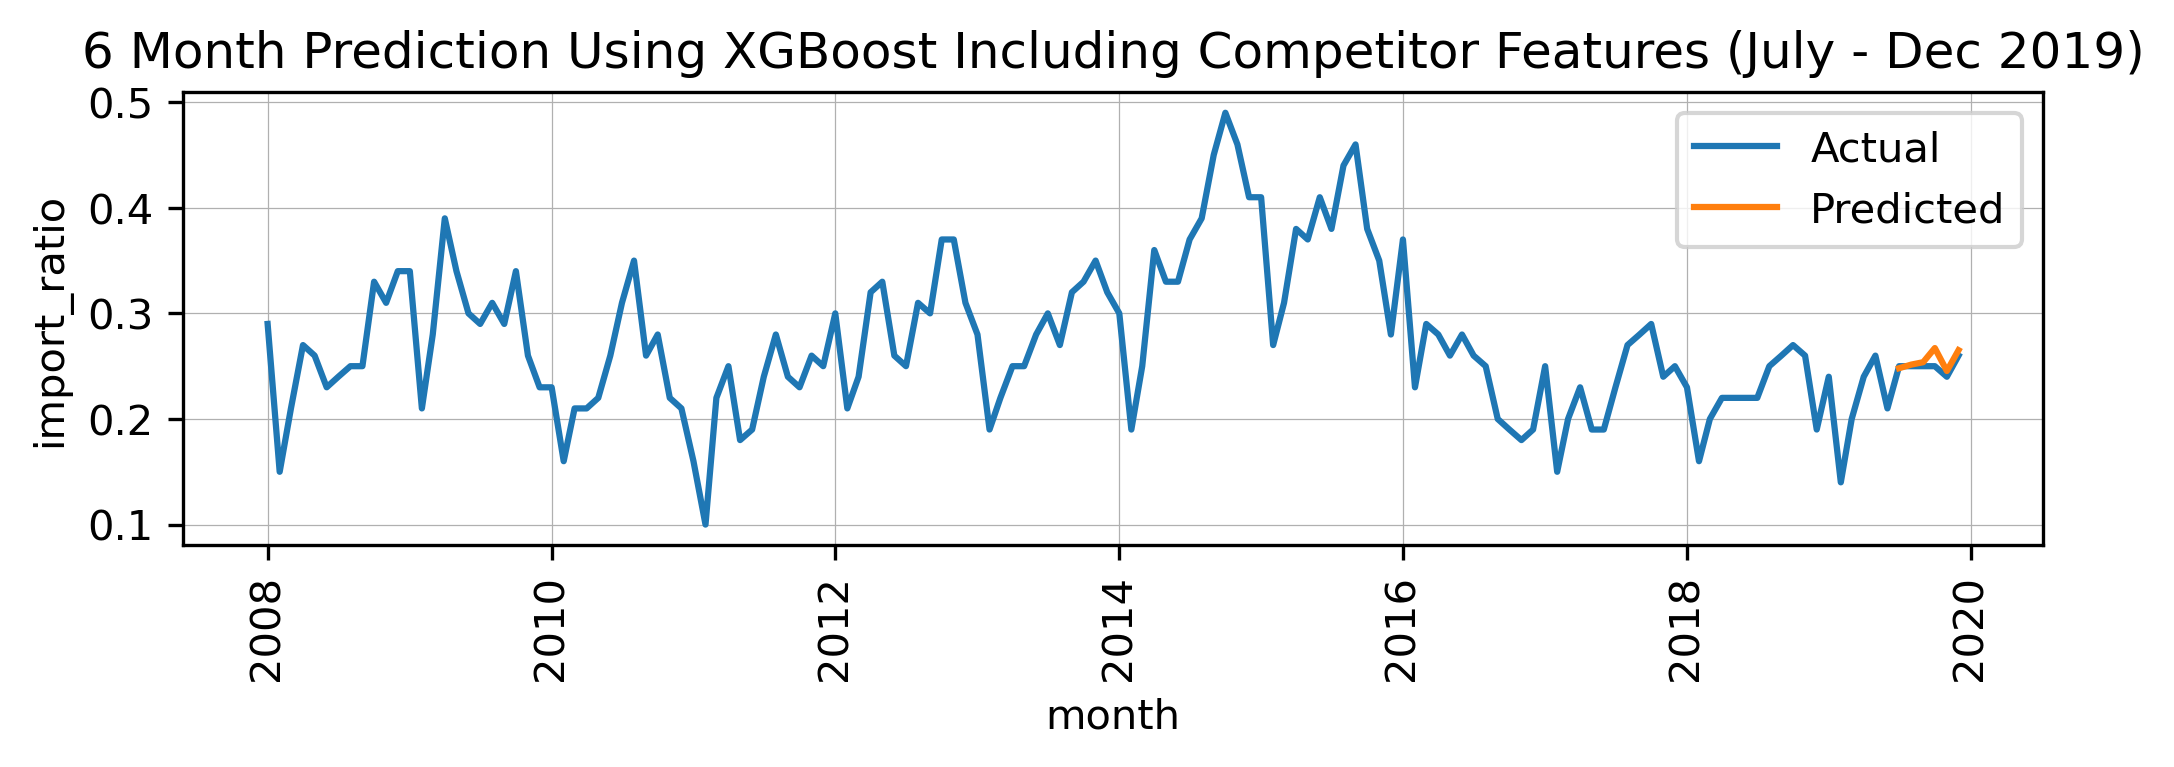

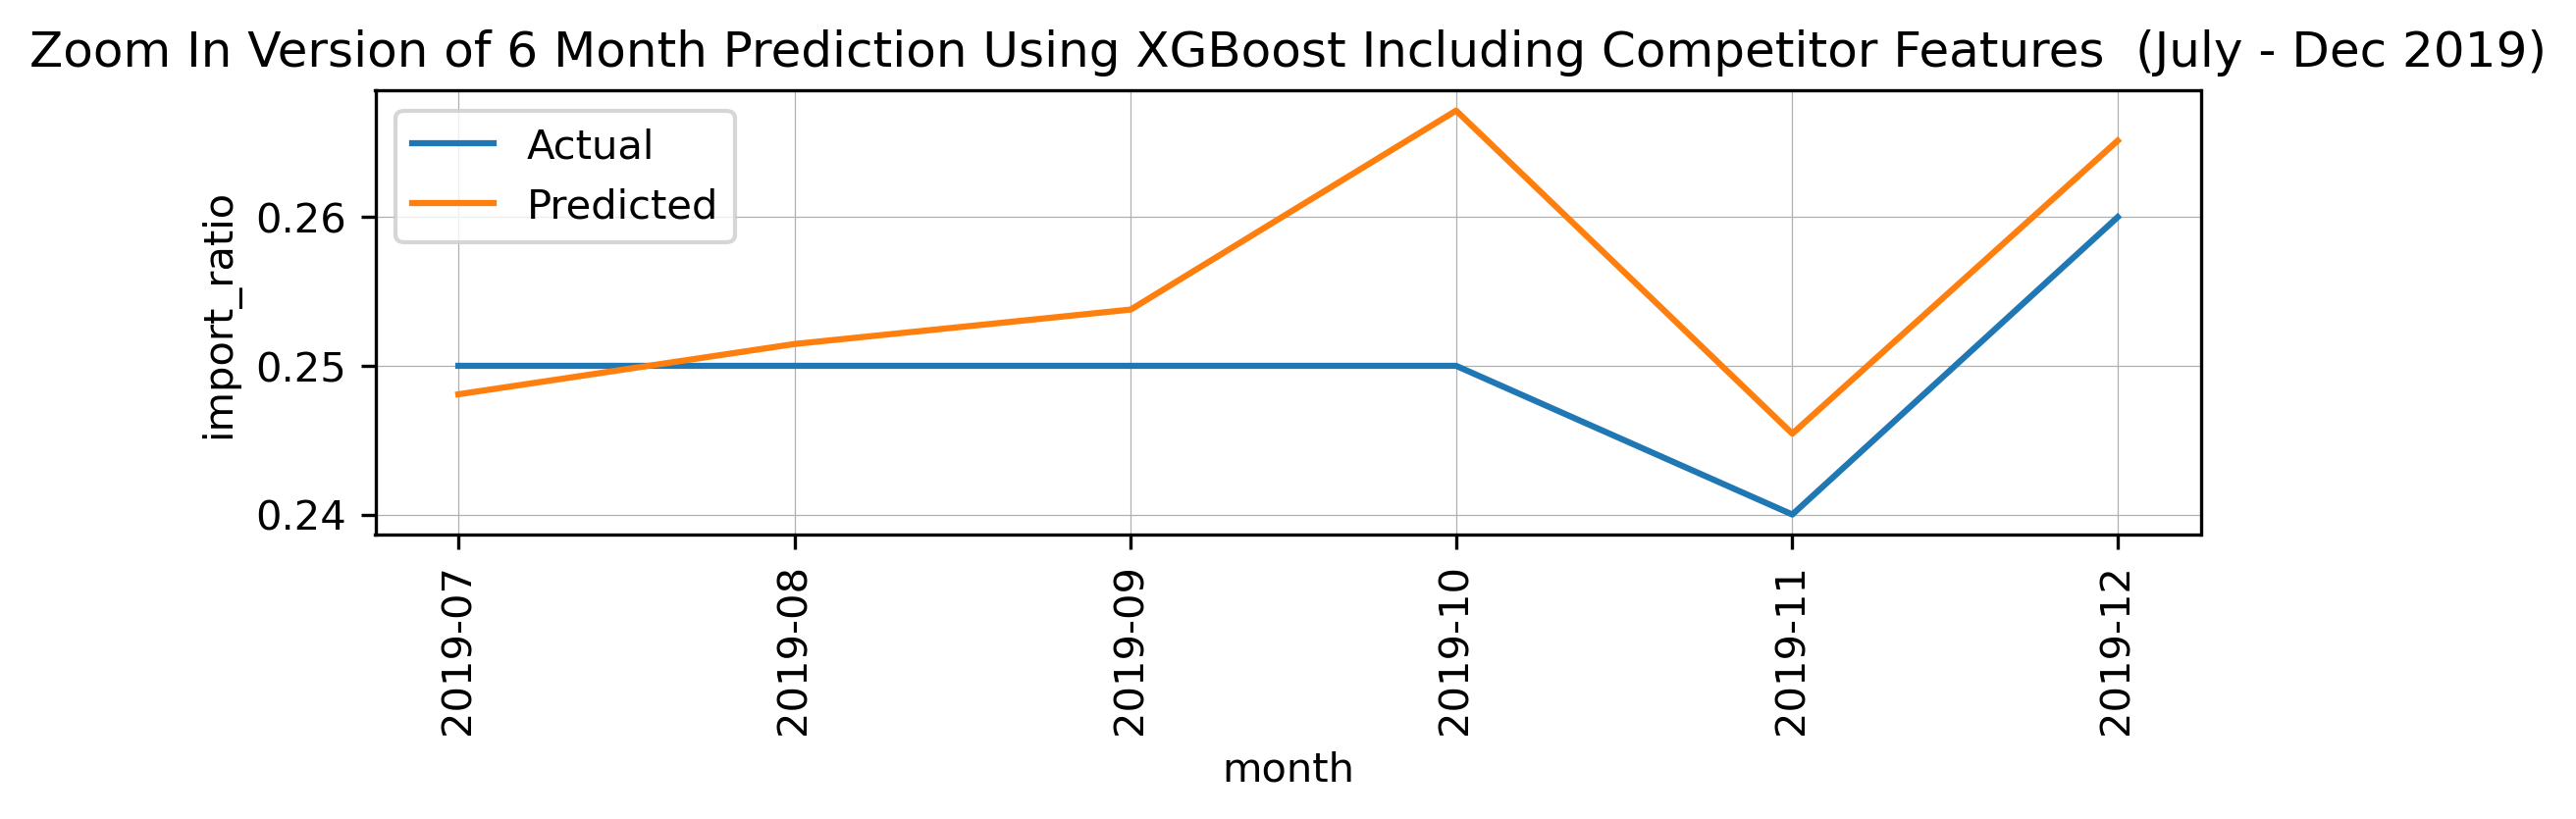

In [11]:
# HAS OUTLIER & 4 Lag feature + 25 features(us, au, ca, nz)
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=best_lag1, x='month', y='import_ratio')
sns.lineplot(data=best_test_df1_lag, x='month', y='predictions').set_title("6 Month Prediction Using XGBoost Including Competitor Features (July - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# zoom in
# simple one
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=best_test_df1_lag, x='month', y='import_ratio')
sns.lineplot(data=best_test_df1_lag, x='month', y='predictions').set_title("Zoom In Version of 6 Month Prediction Using XGBoost Including Competitor Features  (July - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

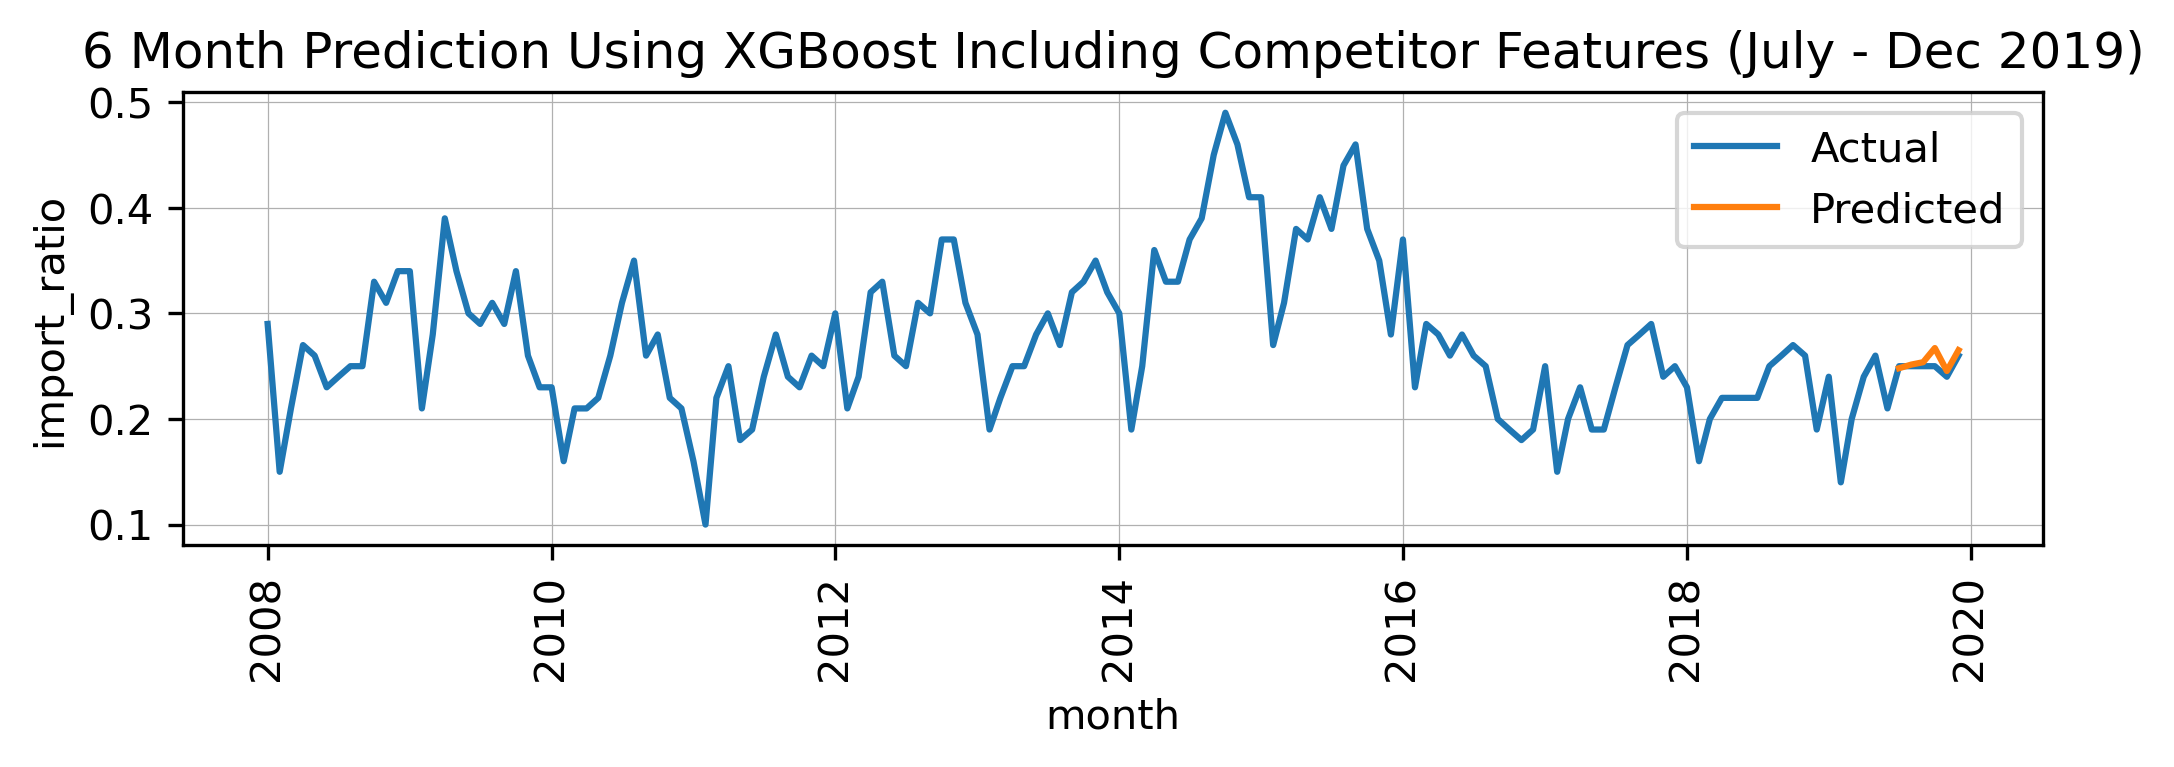

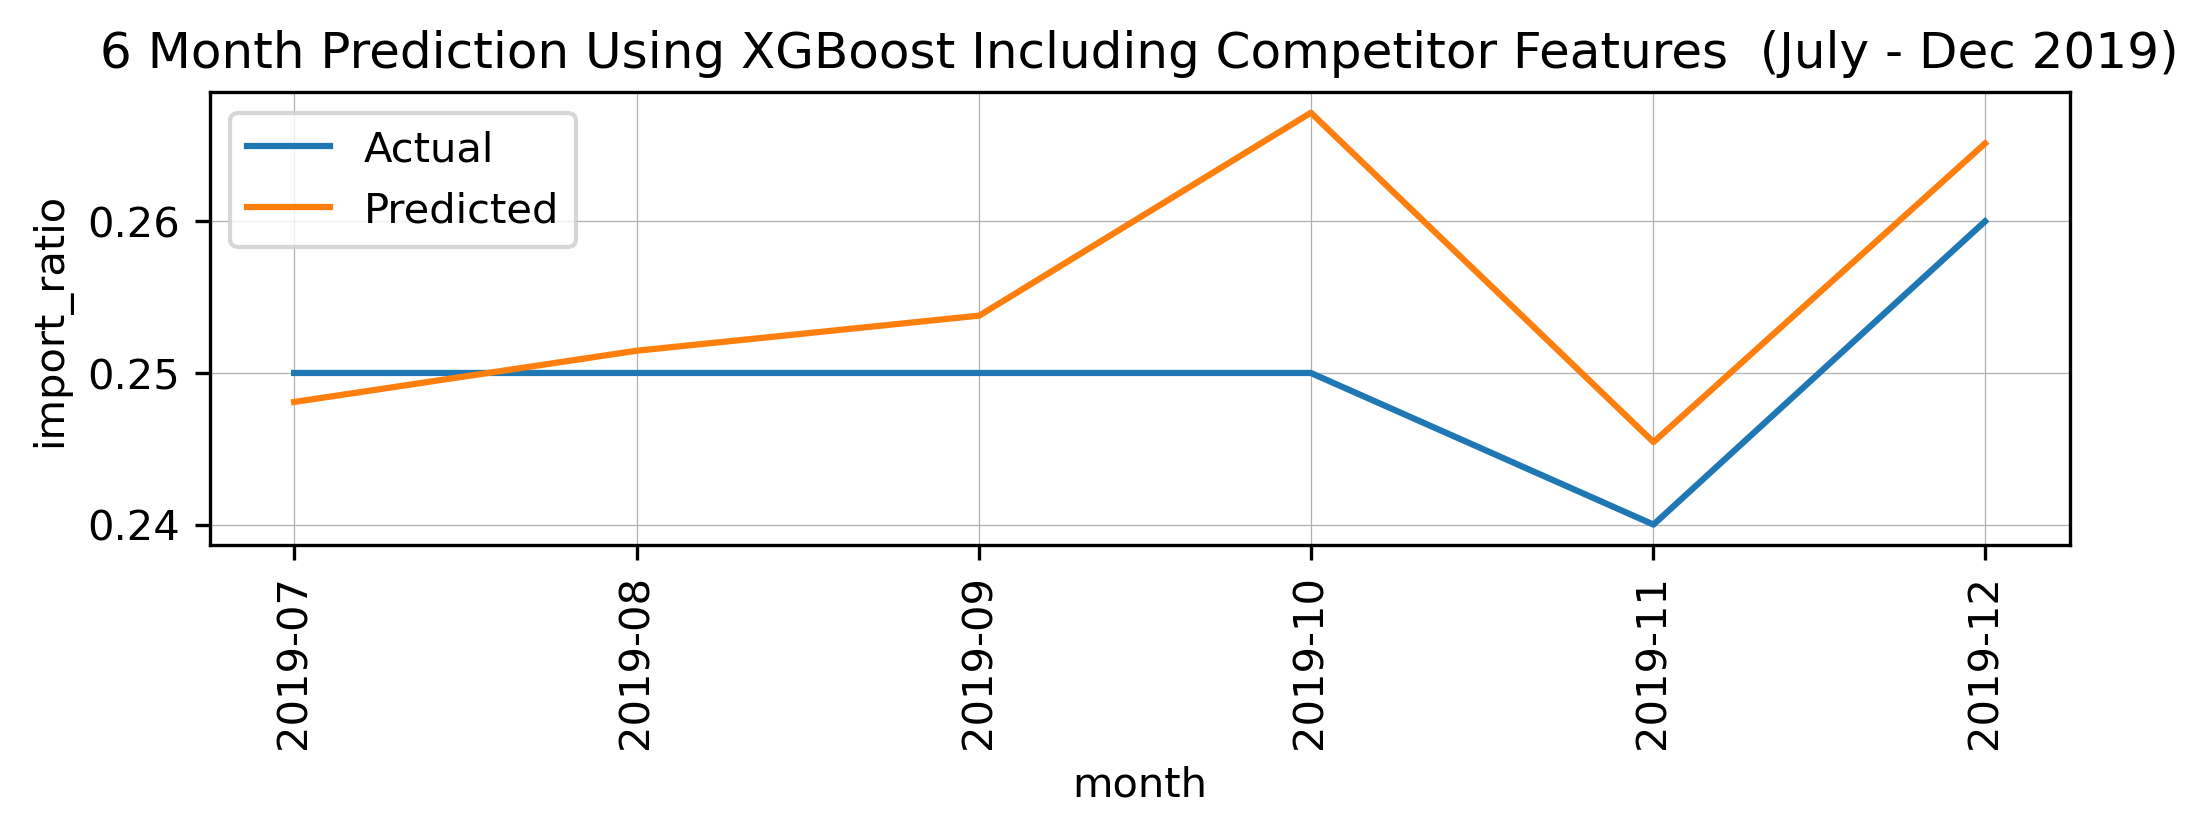

In [12]:
# HAS OUTLIER & 4 Lag feature + 27 features(us, au, ca, nz)
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=best_lag1, x='month', y='import_ratio')
sns.lineplot(data=best_test_df1_lag, x='month', y='predictions').set_title("6 Month Prediction Using XGBoost Including Competitor Features (July - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# zoom in
# simple one
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=best_test_df1_lag, x='month', y='import_ratio')
sns.lineplot(data=best_test_df1_lag, x='month', y='predictions').set_title("6 Month Prediction Using XGBoost Including Competitor Features  (July - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

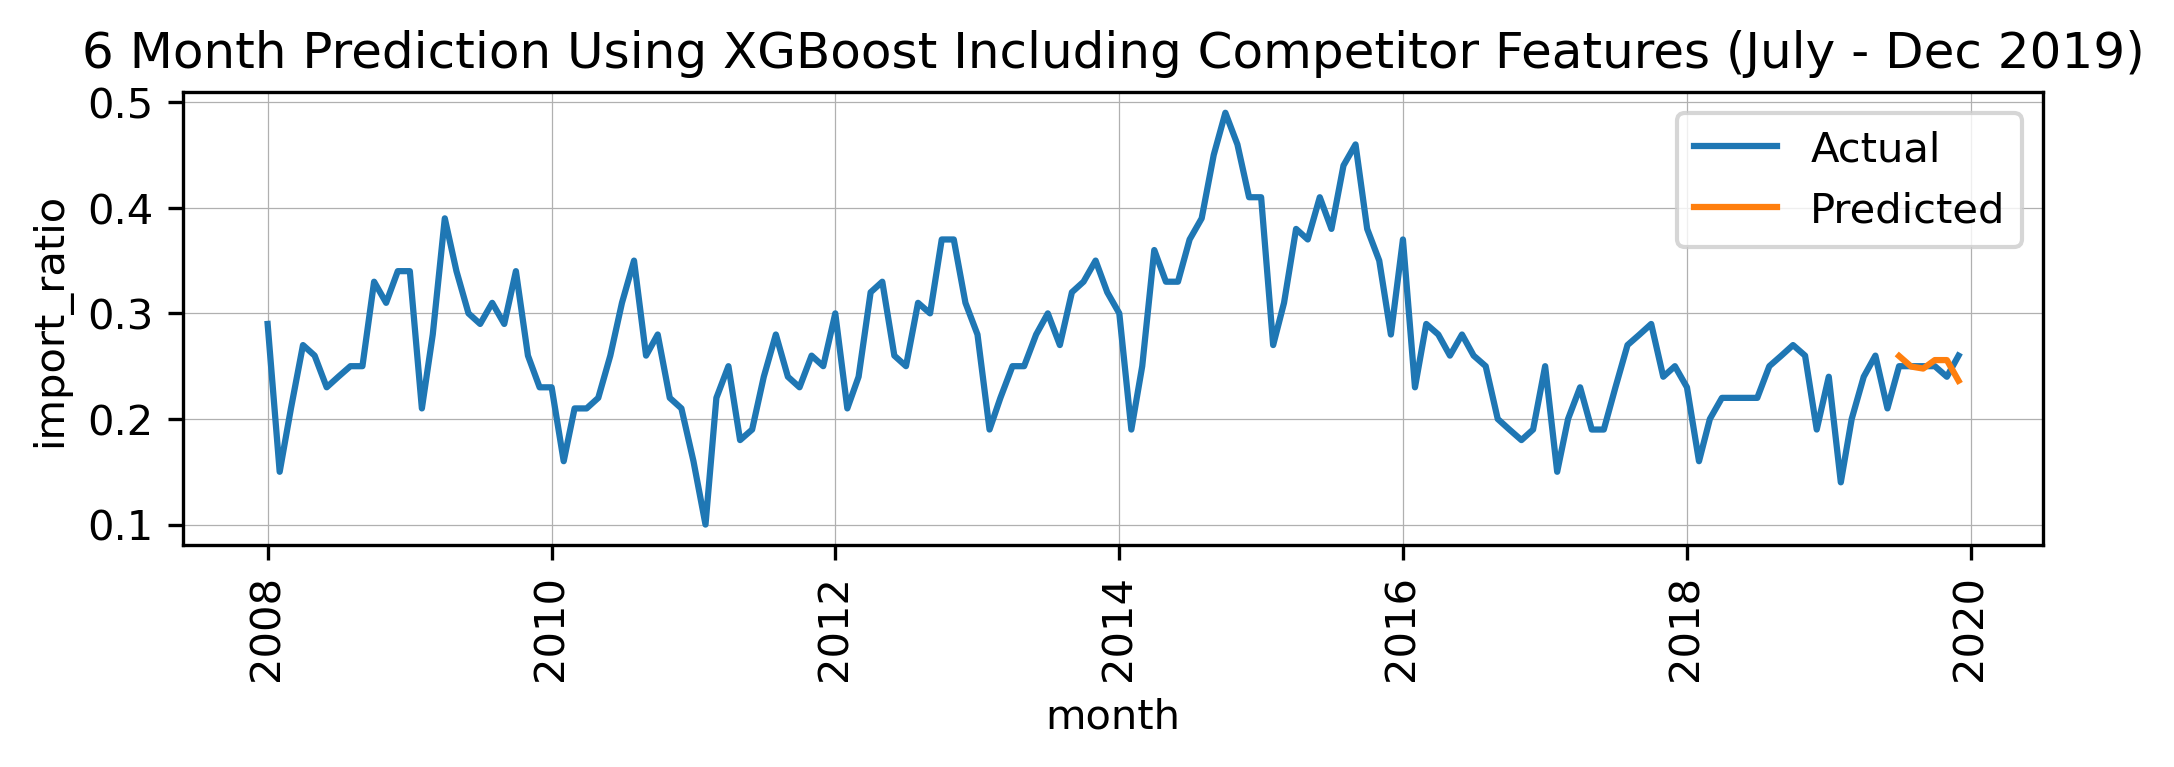

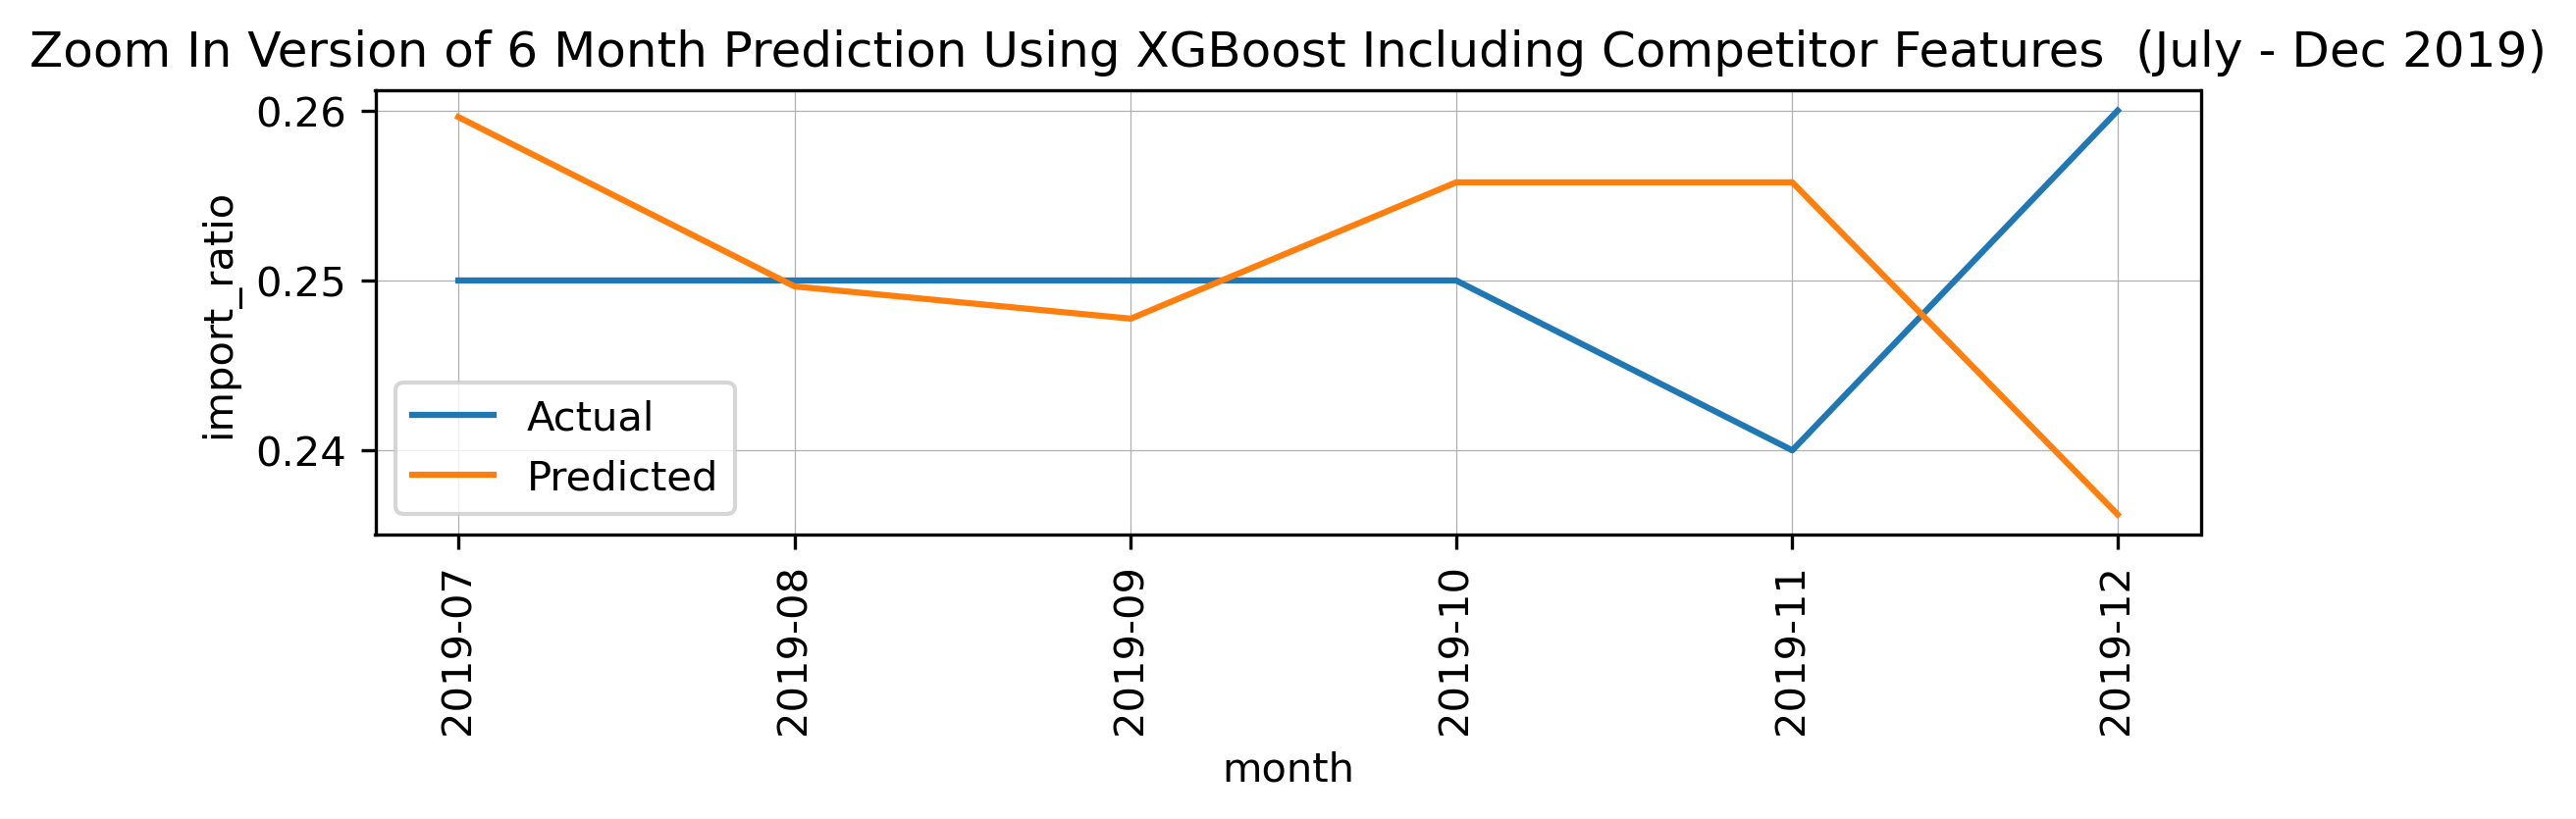

In [26]:
# HAS OUTLIER & 4 Lag feature + 29 features(us, au, ca, nz)
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=best_lag1, x='month', y='import_ratio')
sns.lineplot(data=best_test_df1_lag, x='month', y='predictions').set_title("6 Month Prediction Using XGBoost Including Competitor Features (July - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# zoom in
# simple one
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=best_test_df1_lag, x='month', y='import_ratio')
sns.lineplot(data=best_test_df1_lag, x='month', y='predictions').set_title("Zoom In Version of 6 Month Prediction Using XGBoost Including Competitor Features  (July - Dec 2019)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

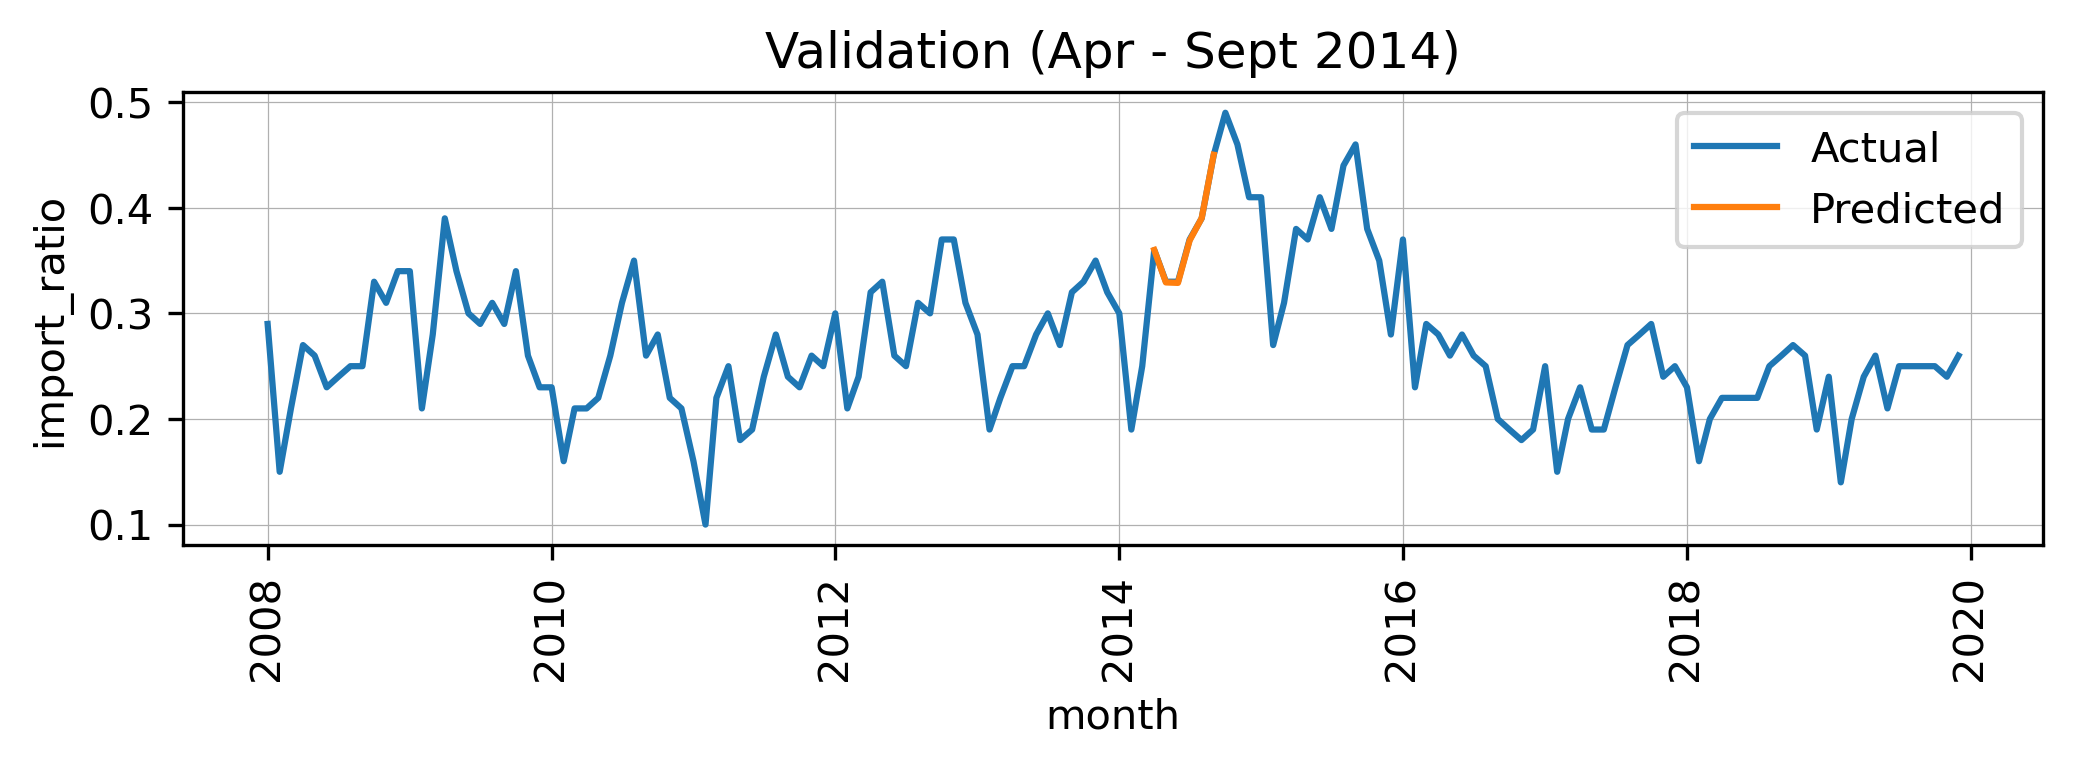

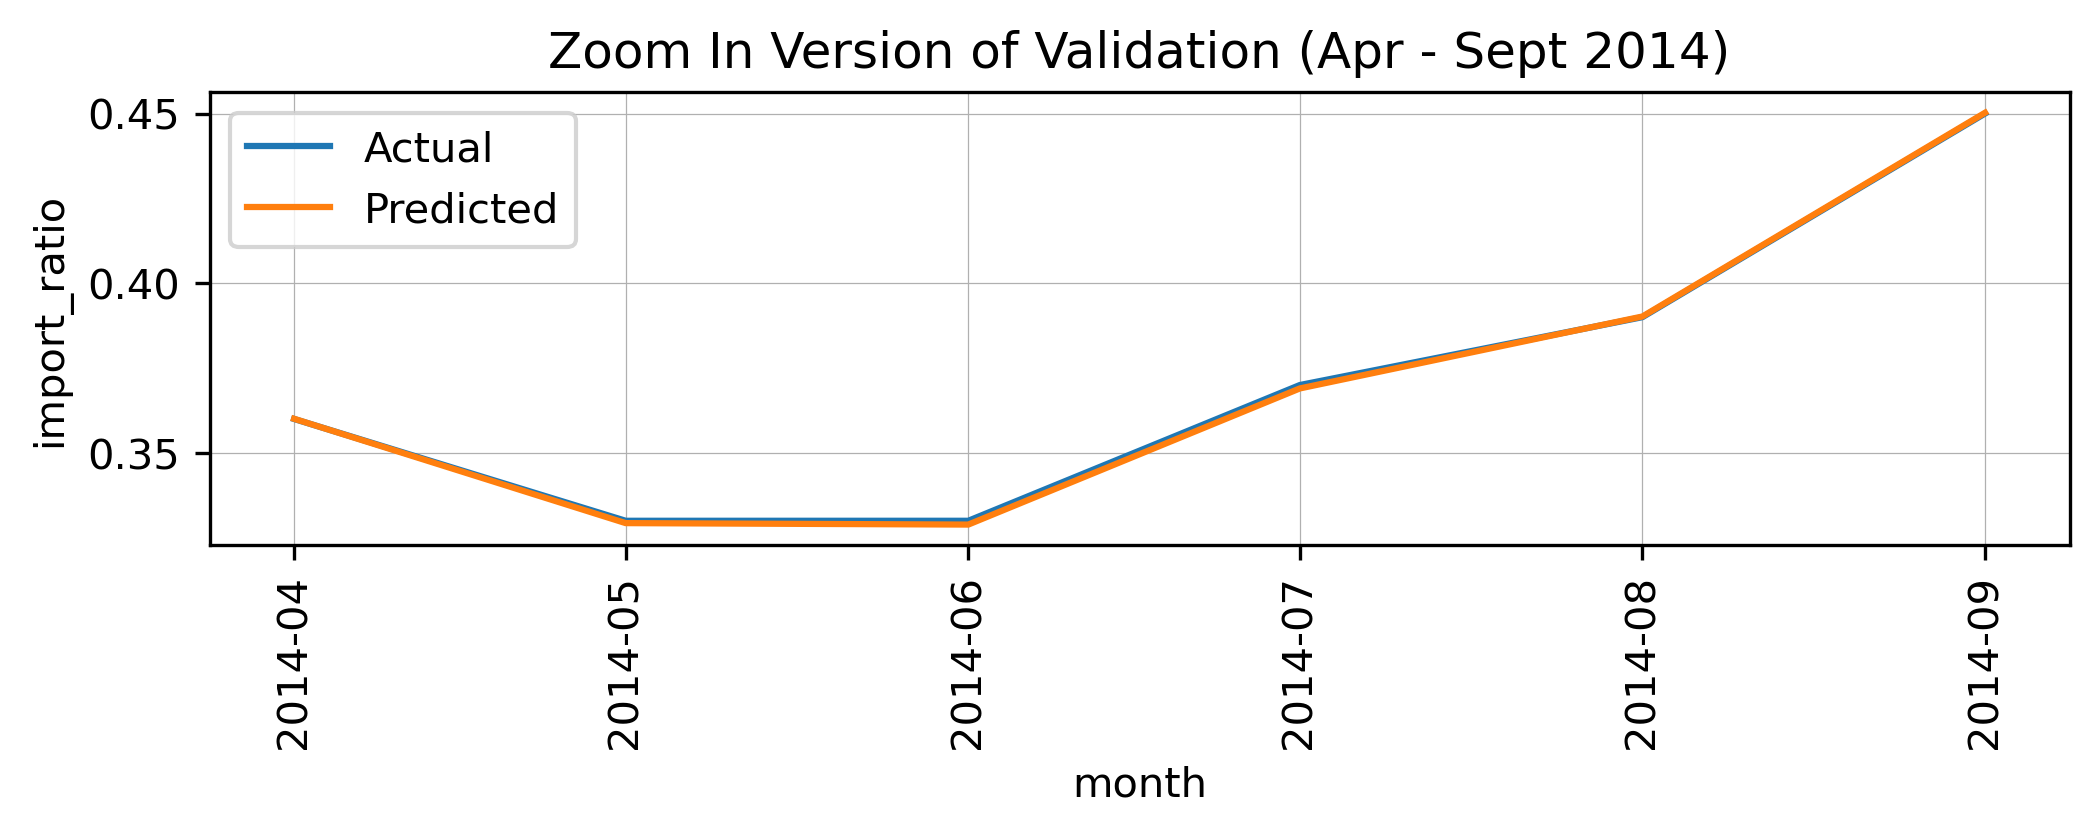

In [156]:
# HAS OUTLIER & Lag feature + 29 us+su+ca+nz features & 2014 validation
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=best_lag1, x='month', y='import_ratio')
sns.lineplot(data=val_df1_lag, x='month', y='predictions').set_title("Validation (Apr - Sept 2014)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# zoom in
# simple one
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=val_df1_lag, x='month', y='import_ratio')
sns.lineplot(data=val_df1_lag, x='month', y='predictions').set_title("Zoom In Version of Validation (Apr - Sept 2014)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

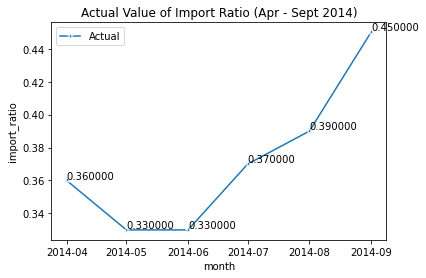

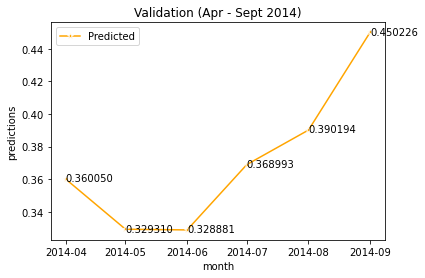

In [157]:
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter

# HAS OUTLIER & Lag feature + 29 us+su+ca+nz features & 2016 validation
plt.show()

#plt.rcParams.update({'figure.figsize': (5, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
a = sns.lineplot(data=val_df1_lag, x='month',
                 y='import_ratio',marker='*').set_title("Actual Value of Import Ratio (Apr - Sept 2014)")

#ax.set_xlabel('Month', fontsize=7)
#ax.set_ylabel('Import Ratio', fontsize=7)

# label points on the plot
for x, y in zip(val_df1_lag['month'], val_df1_lag['import_ratio']):
     plt.text(x = x, 
             y = y+0.001, 
             s = '{:.6f}'.format(y), fontsize=10)
        
ax.legend(['Actual']) 


#plt.rcParams.update({'figure.figsize': (5, 2), 'figure.dpi':300})
fig, ax = plt.subplots()

b = sns.lineplot(data=val_df1_lag, x='month', y='predictions', 
                 marker='*', color = 'orange').set_title("Validation (Apr - Sept 2014)")


# label points on the plot
for x, y in zip(val_df1_lag['month'], val_df1_lag['predictions']):
    plt.text(x = x, 
          y = y-0.0015, 
          s = '{:.6f}'.format(y), fontsize=10)

ax.legend(['Predicted'])

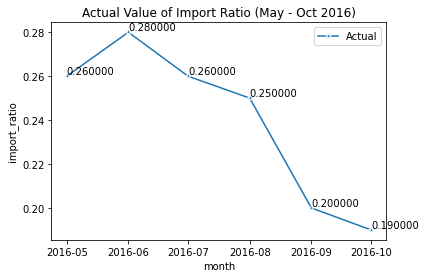

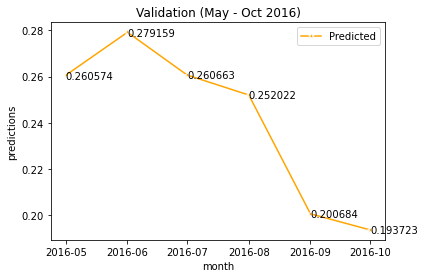

In [160]:
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter

# HAS OUTLIER & Lag feature + 29 us+su+ca+nz features & 2016 validation
plt.show()

#plt.rcParams.update({'figure.figsize': (5, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
a = sns.lineplot(data=val_df1_lag, x='month',
                 y='import_ratio',marker='*').set_title("Actual Value of Import Ratio (May - Oct 2016)")

#ax.set_xlabel('Month', fontsize=7)
#ax.set_ylabel('Import Ratio', fontsize=7)

# label points on the plot
for x, y in zip(val_df1_lag['month'], val_df1_lag['import_ratio']):
     plt.text(x = x, 
             y = y+0.001, 
             s = '{:.6f}'.format(y), fontsize=10)
        
ax.legend(['Actual']) 


#plt.rcParams.update({'figure.figsize': (5, 2), 'figure.dpi':300})
fig, ax = plt.subplots()

b = sns.lineplot(data=val_df1_lag, x='month', y='predictions', 
                 marker='*', color = 'orange').set_title("Validation (May - Oct 2016)")


# label points on the plot
for x, y in zip(val_df1_lag['month'], val_df1_lag['predictions']):
    plt.text(x = x, 
          y = y-0.0015, 
          s = '{:.6f}'.format(y), fontsize=10)

ax.legend(['Predicted'])

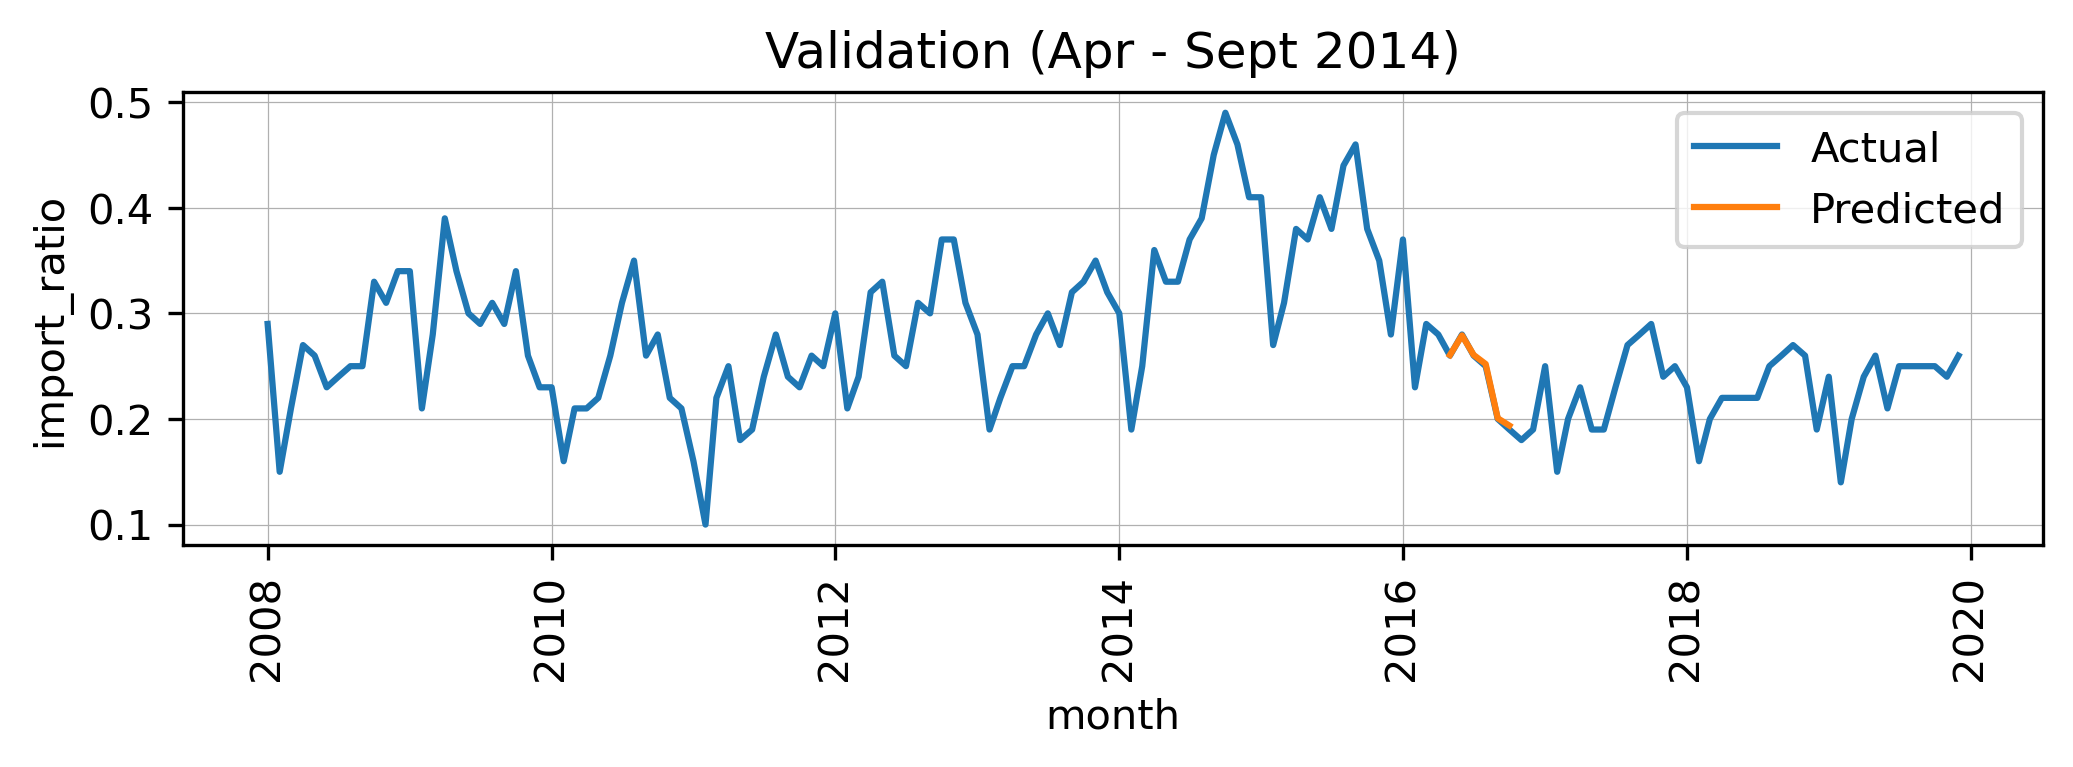

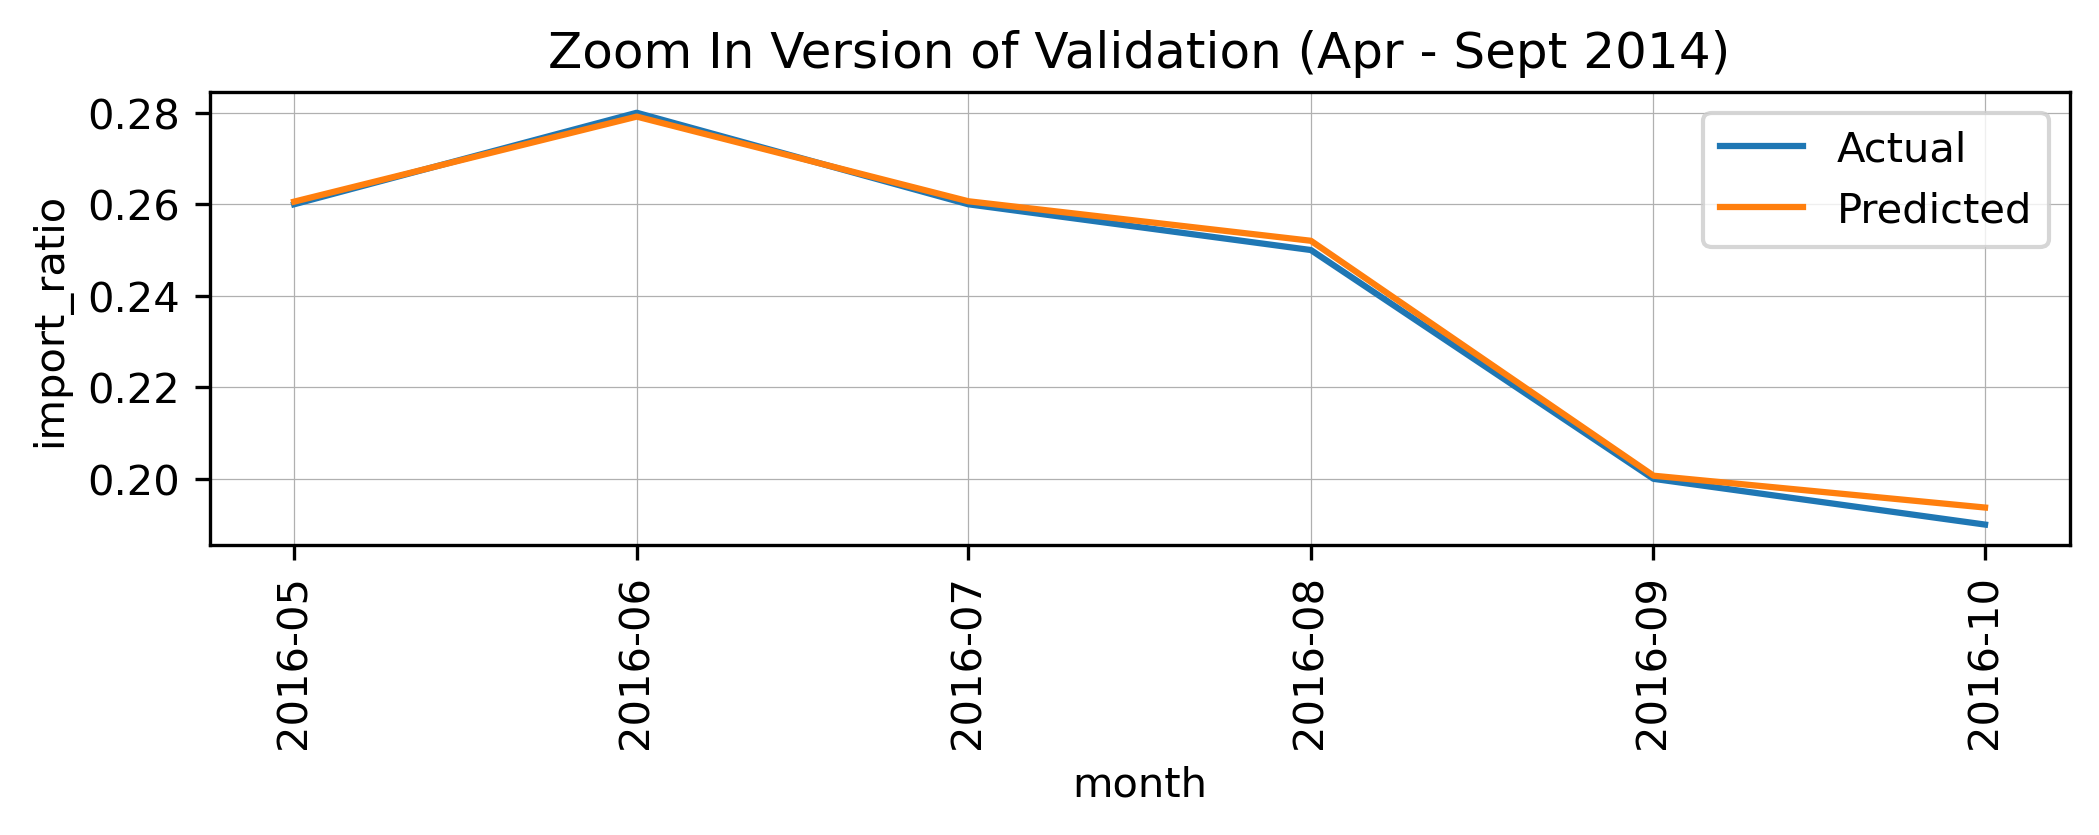

In [161]:
# HAS OUTLIER & Lag feature + 29 us+su+ca+nz features & 2014 validation
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=best_lag1, x='month', y='import_ratio')
sns.lineplot(data=val_df1_lag, x='month', y='predictions').set_title("Validation (Apr - Sept 2014)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# zoom in
# simple one
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=val_df1_lag, x='month', y='import_ratio')
sns.lineplot(data=val_df1_lag, x='month', y='predictions').set_title("Zoom In Version of Validation (Apr - Sept 2014)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

In [ ]:
%matplotlib inline
from matplotlib.ticker import FormatStrFormatter

# HAS OUTLIER & Lag feature + 29 us+su+ca+nz features & 2016 validation
plt.show()

#plt.rcParams.update({'figure.figsize': (5, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
a = sns.lineplot(data=val_df1_lag, x='month',
                 y='import_ratio',marker='*').set_title("Actual Value of Import Ratio (Jan - June 2016)")

#ax.set_xlabel('Month', fontsize=7)
#ax.set_ylabel('Import Ratio', fontsize=7)

# label points on the plot
for x, y in zip(val_df1_lag['month'], val_df1_lag['import_ratio']):
     plt.text(x = x, 
             y = y+0.001, 
             s = '{:.6f}'.format(y), fontsize=10)
        
ax.legend(['Actual']) 


#plt.rcParams.update({'figure.figsize': (5, 2), 'figure.dpi':300})
fig, ax = plt.subplots()

b = sns.lineplot(data=val_df1_lag, x='month', y='predictions', 
                 marker='*', color = 'orange').set_title("Validation (Jan - June 2016)")


# label points on the plot
for x, y in zip(val_df1_lag['month'], val_df1_lag['predictions']):
    plt.text(x = x, 
          y = y-0.0015, 
          s = '{:.6f}'.format(y), fontsize=10)

ax.legend(['Predicted'])

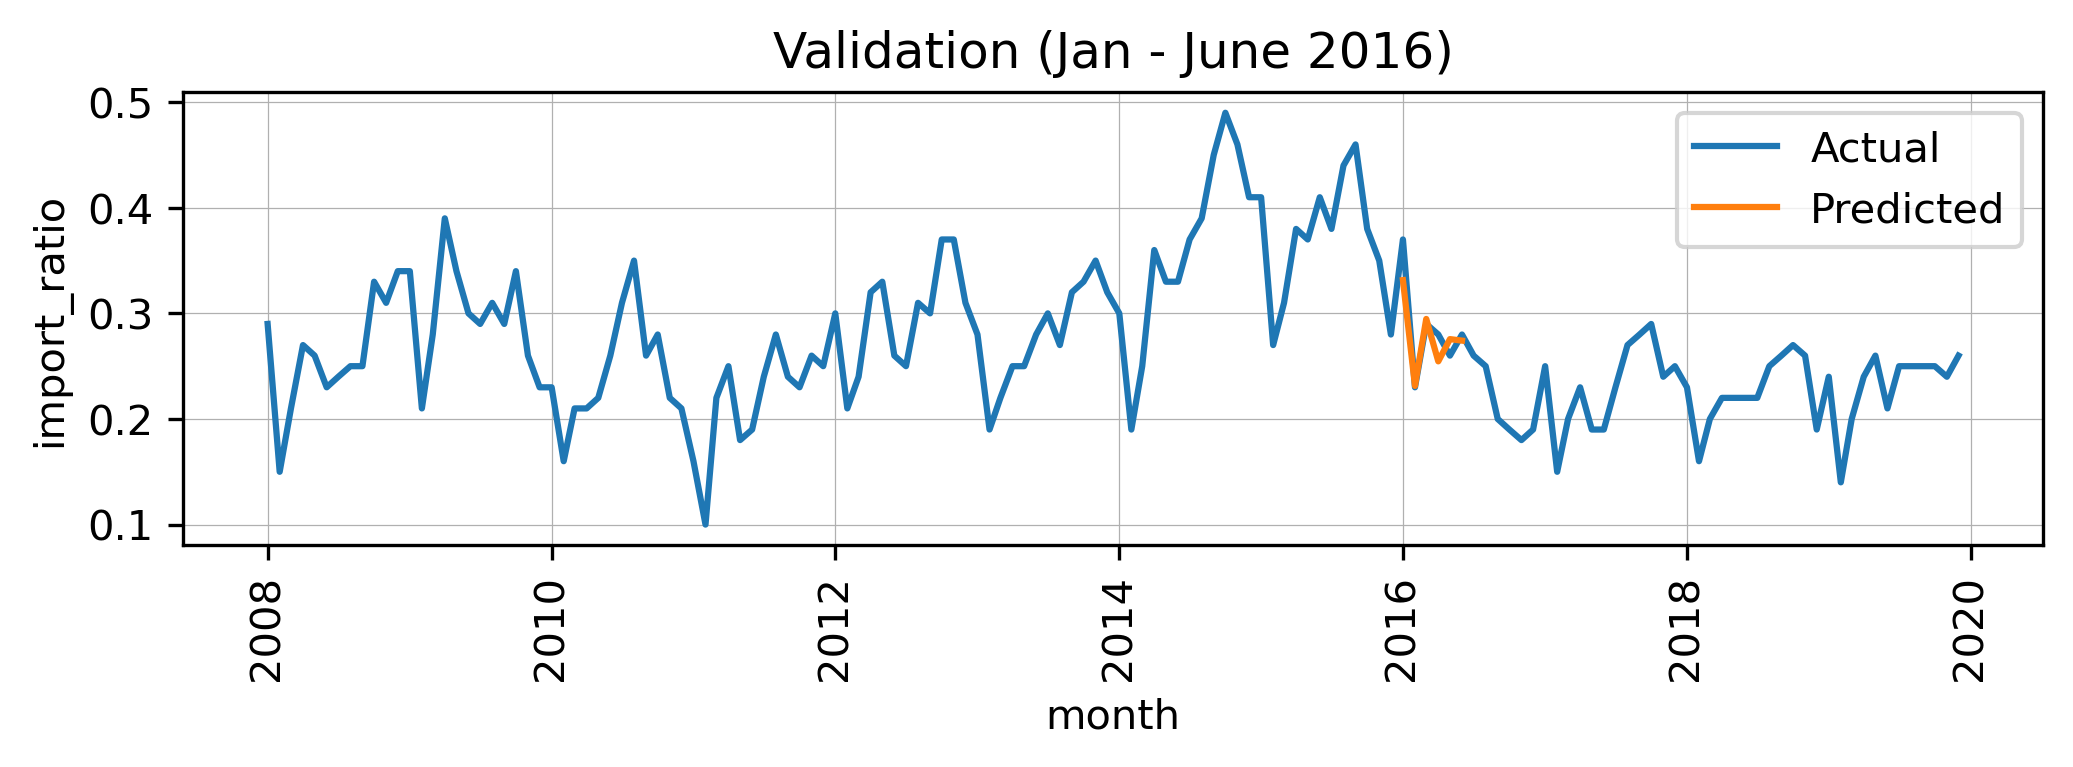

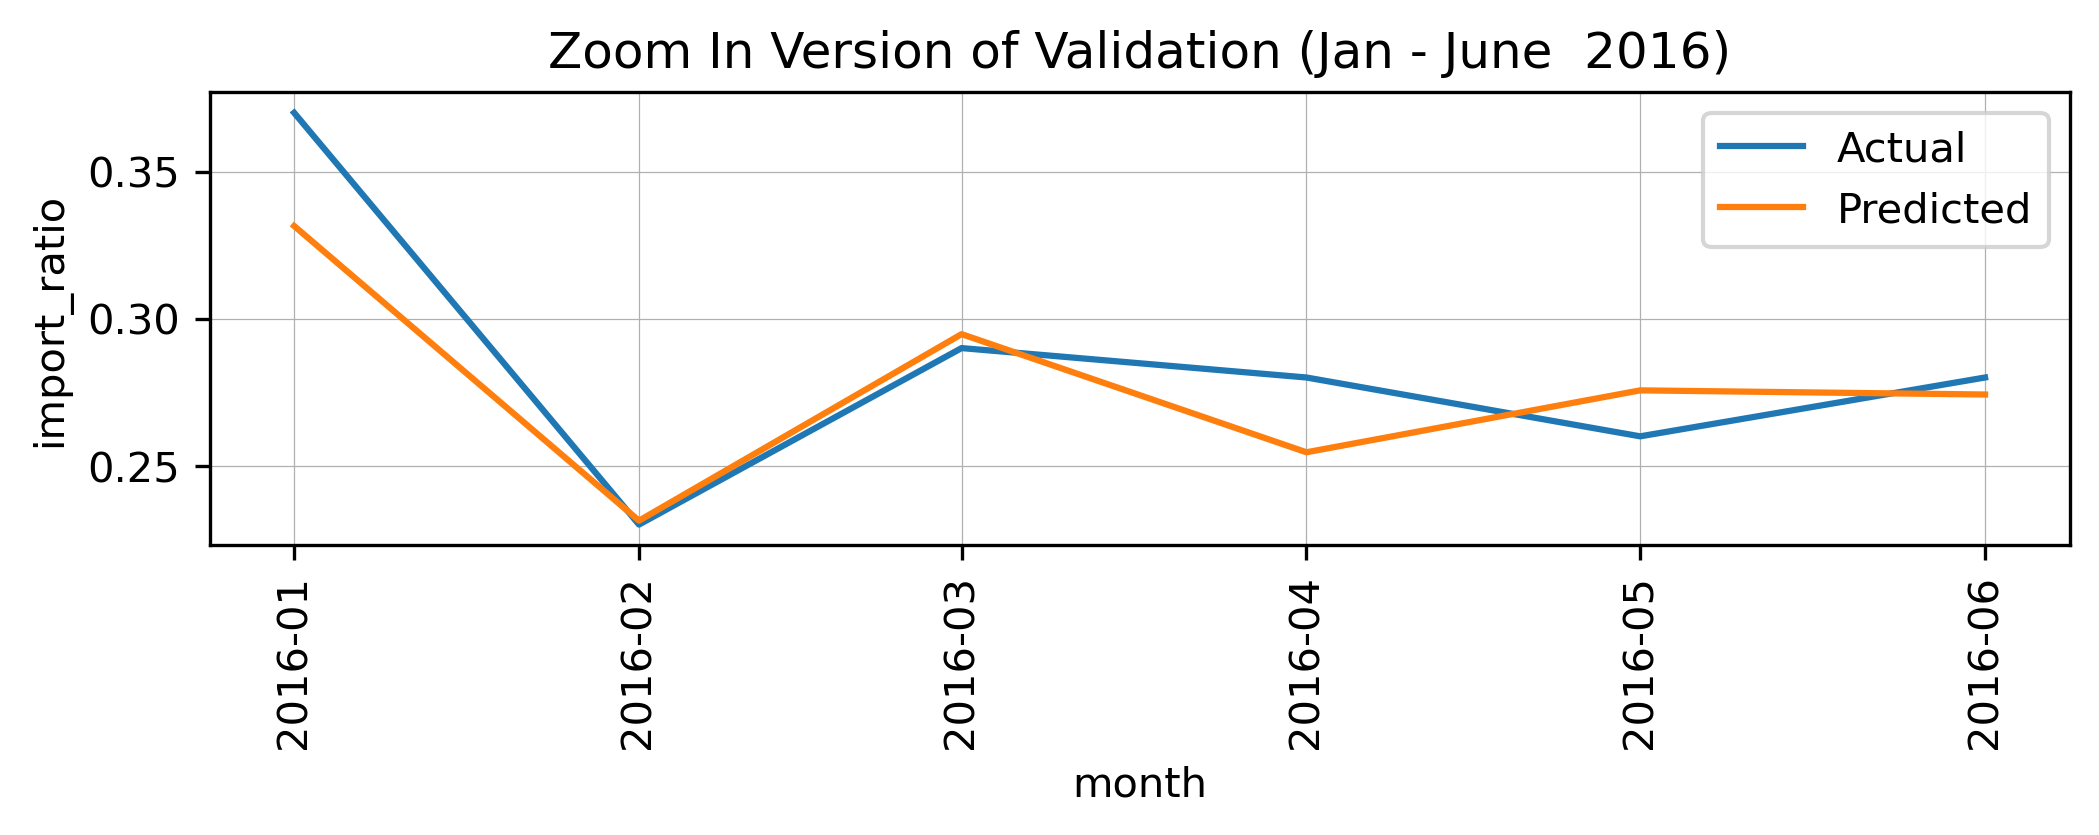

In [91]:
# HAS OUTLIER & Lag feature + 29 us+su+ca+nz features & 2016 validation
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=best_lag1, x='month', y='import_ratio')
sns.lineplot(data=val_df1_lag, x='month', y='predictions').set_title("Validation (Jan - June 2016)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

# zoom in
# simple one
plt.rcParams.update({'figure.figsize': (8, 2), 'figure.dpi':300})
fig, ax = plt.subplots()
sns.lineplot(data=val_df1_lag, x='month', y='import_ratio')
sns.lineplot(data=val_df1_lag, x='month', y='predictions').set_title("Zoom In Version of Validation (Jan - June  2016)")
ax.legend(['Actual', 'Predicted'])
plt.grid(linestyle='-', linewidth=0.3)
ax.tick_params(axis='x', rotation=90)

## Model Output Explaination Using Shap

In [13]:
# compute the SHAP values for every prediction in the validation dataset
explainer_has_outlier = shap.TreeExplainer(best_model)
shap_values_has_outlier = explainer_has_outlier(best_X_test_lag)
#shap_values = explainer.shap_values(X_importance)

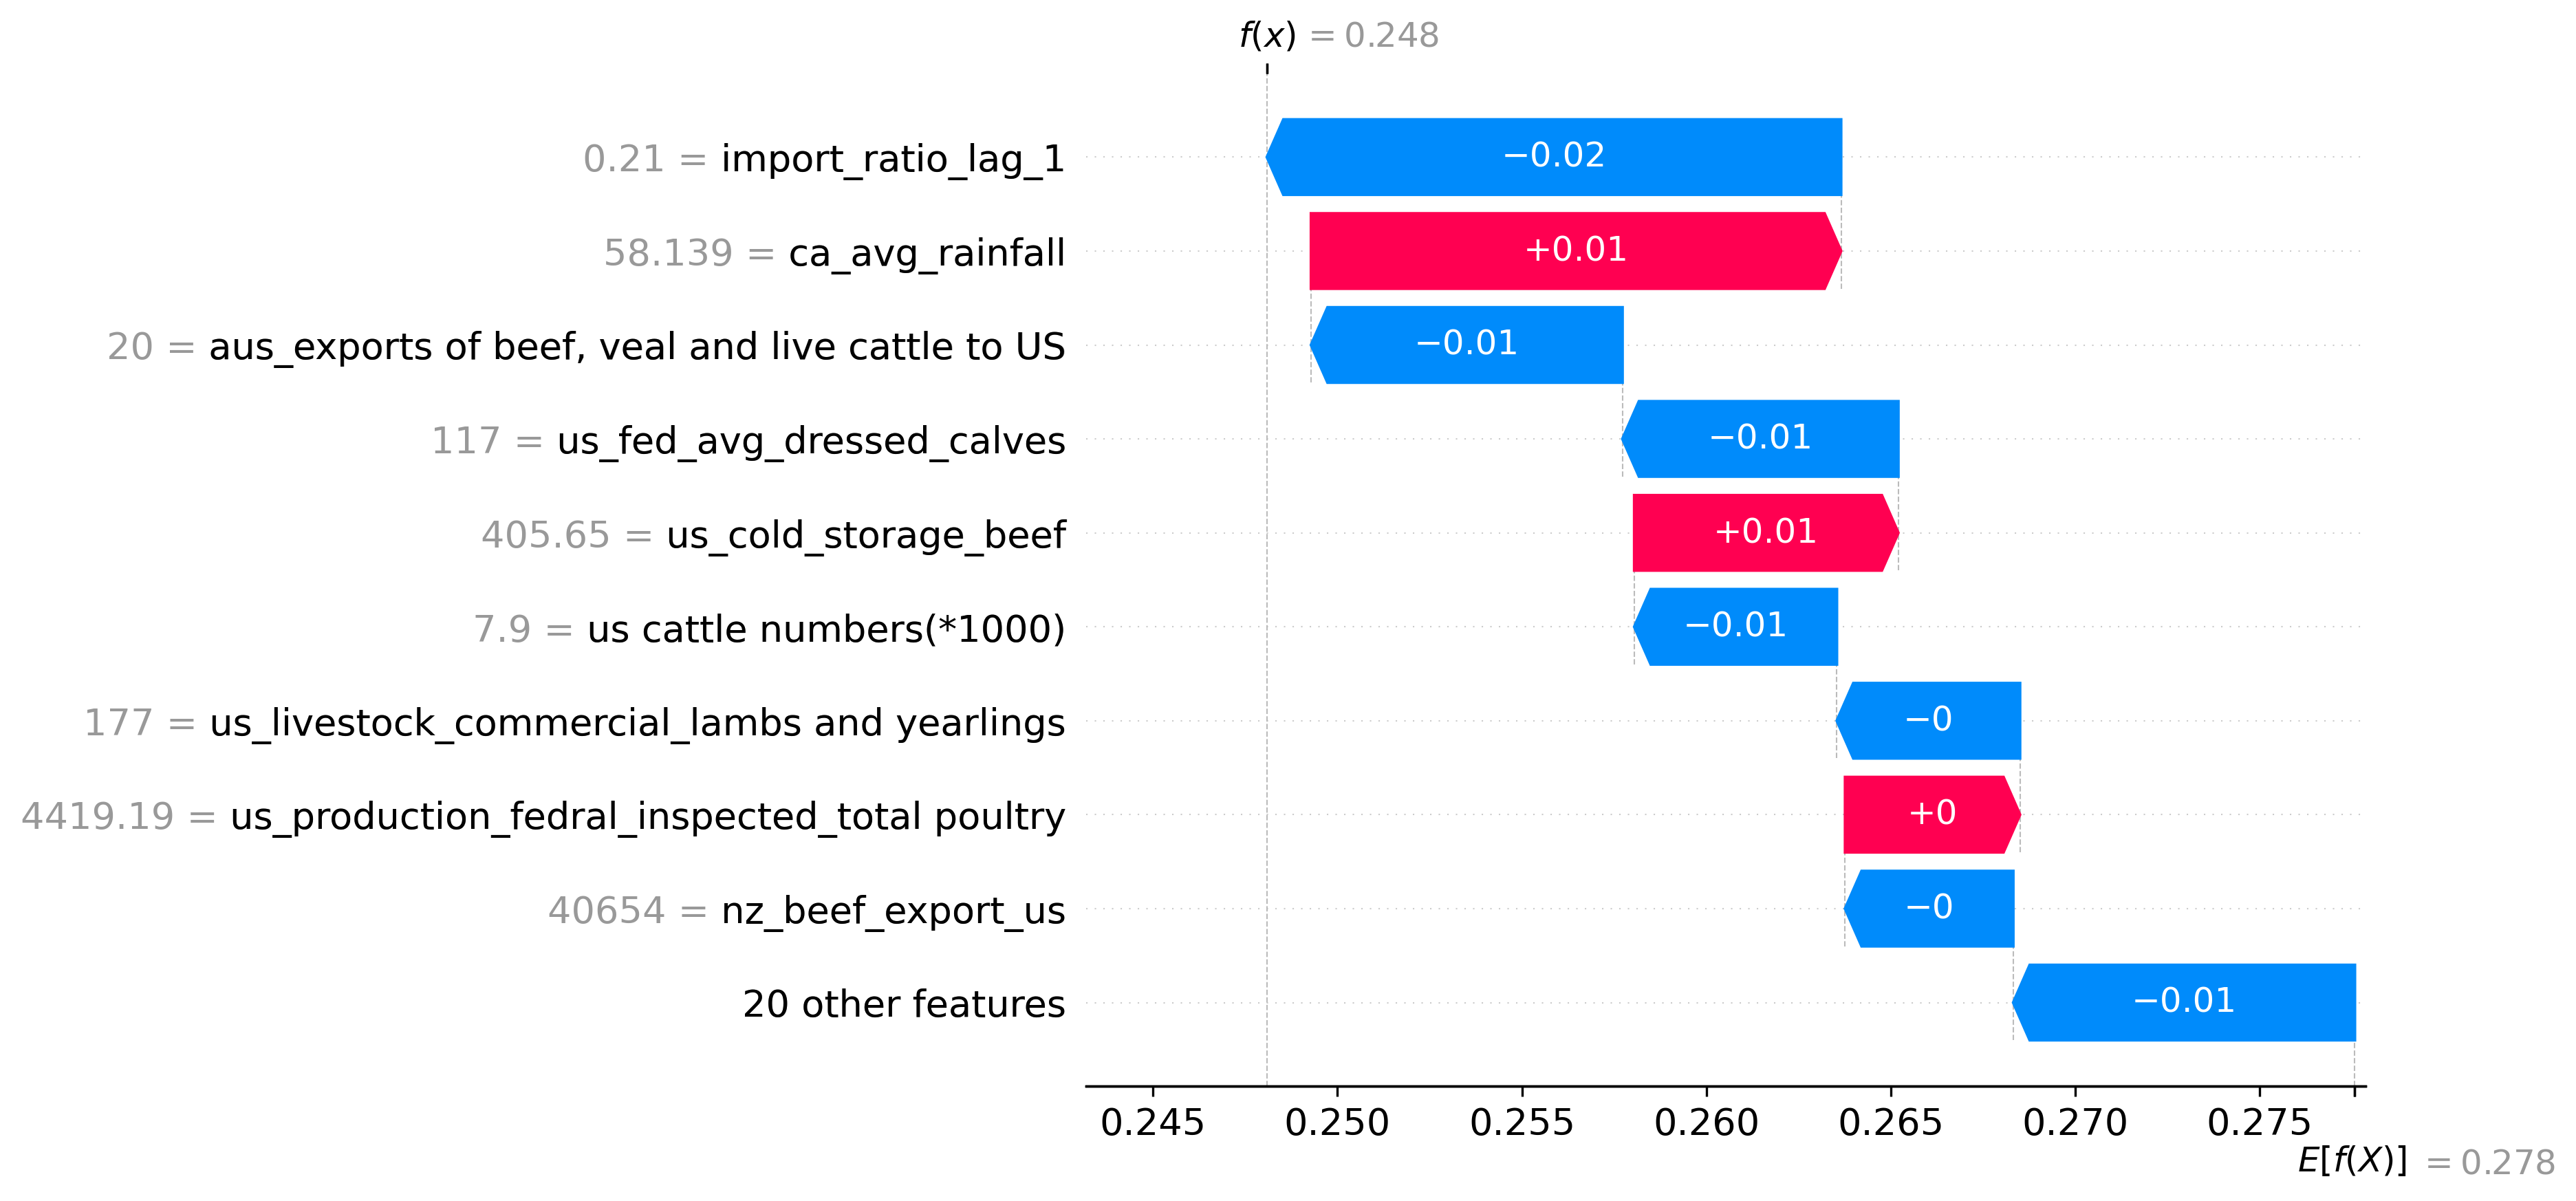

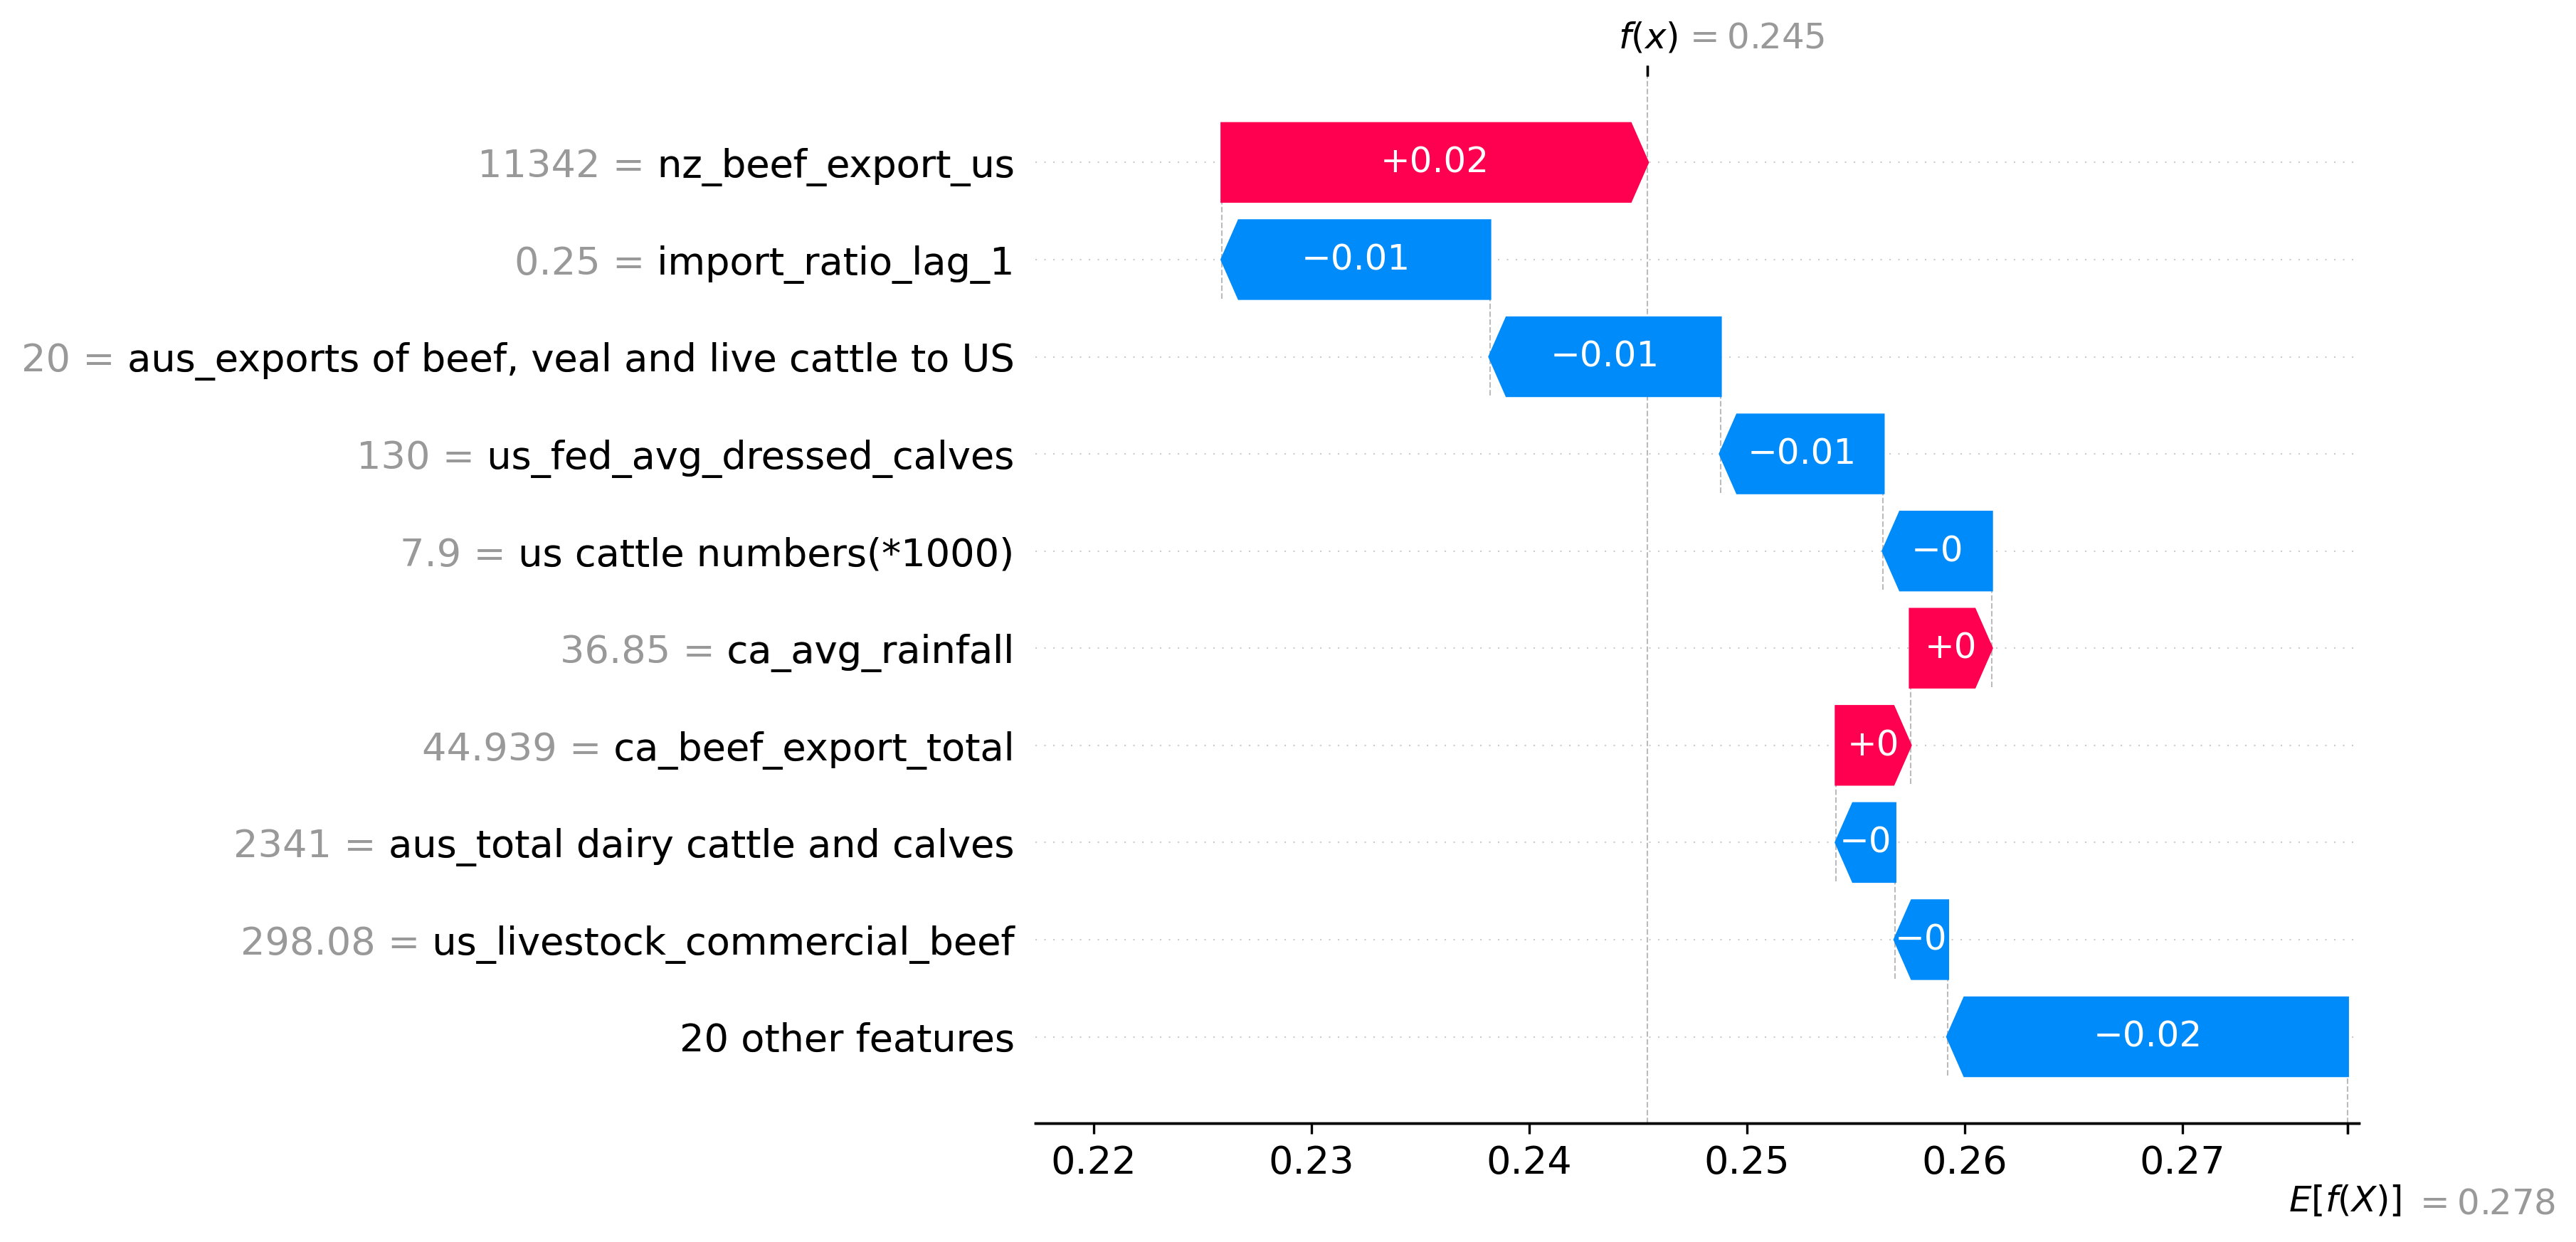

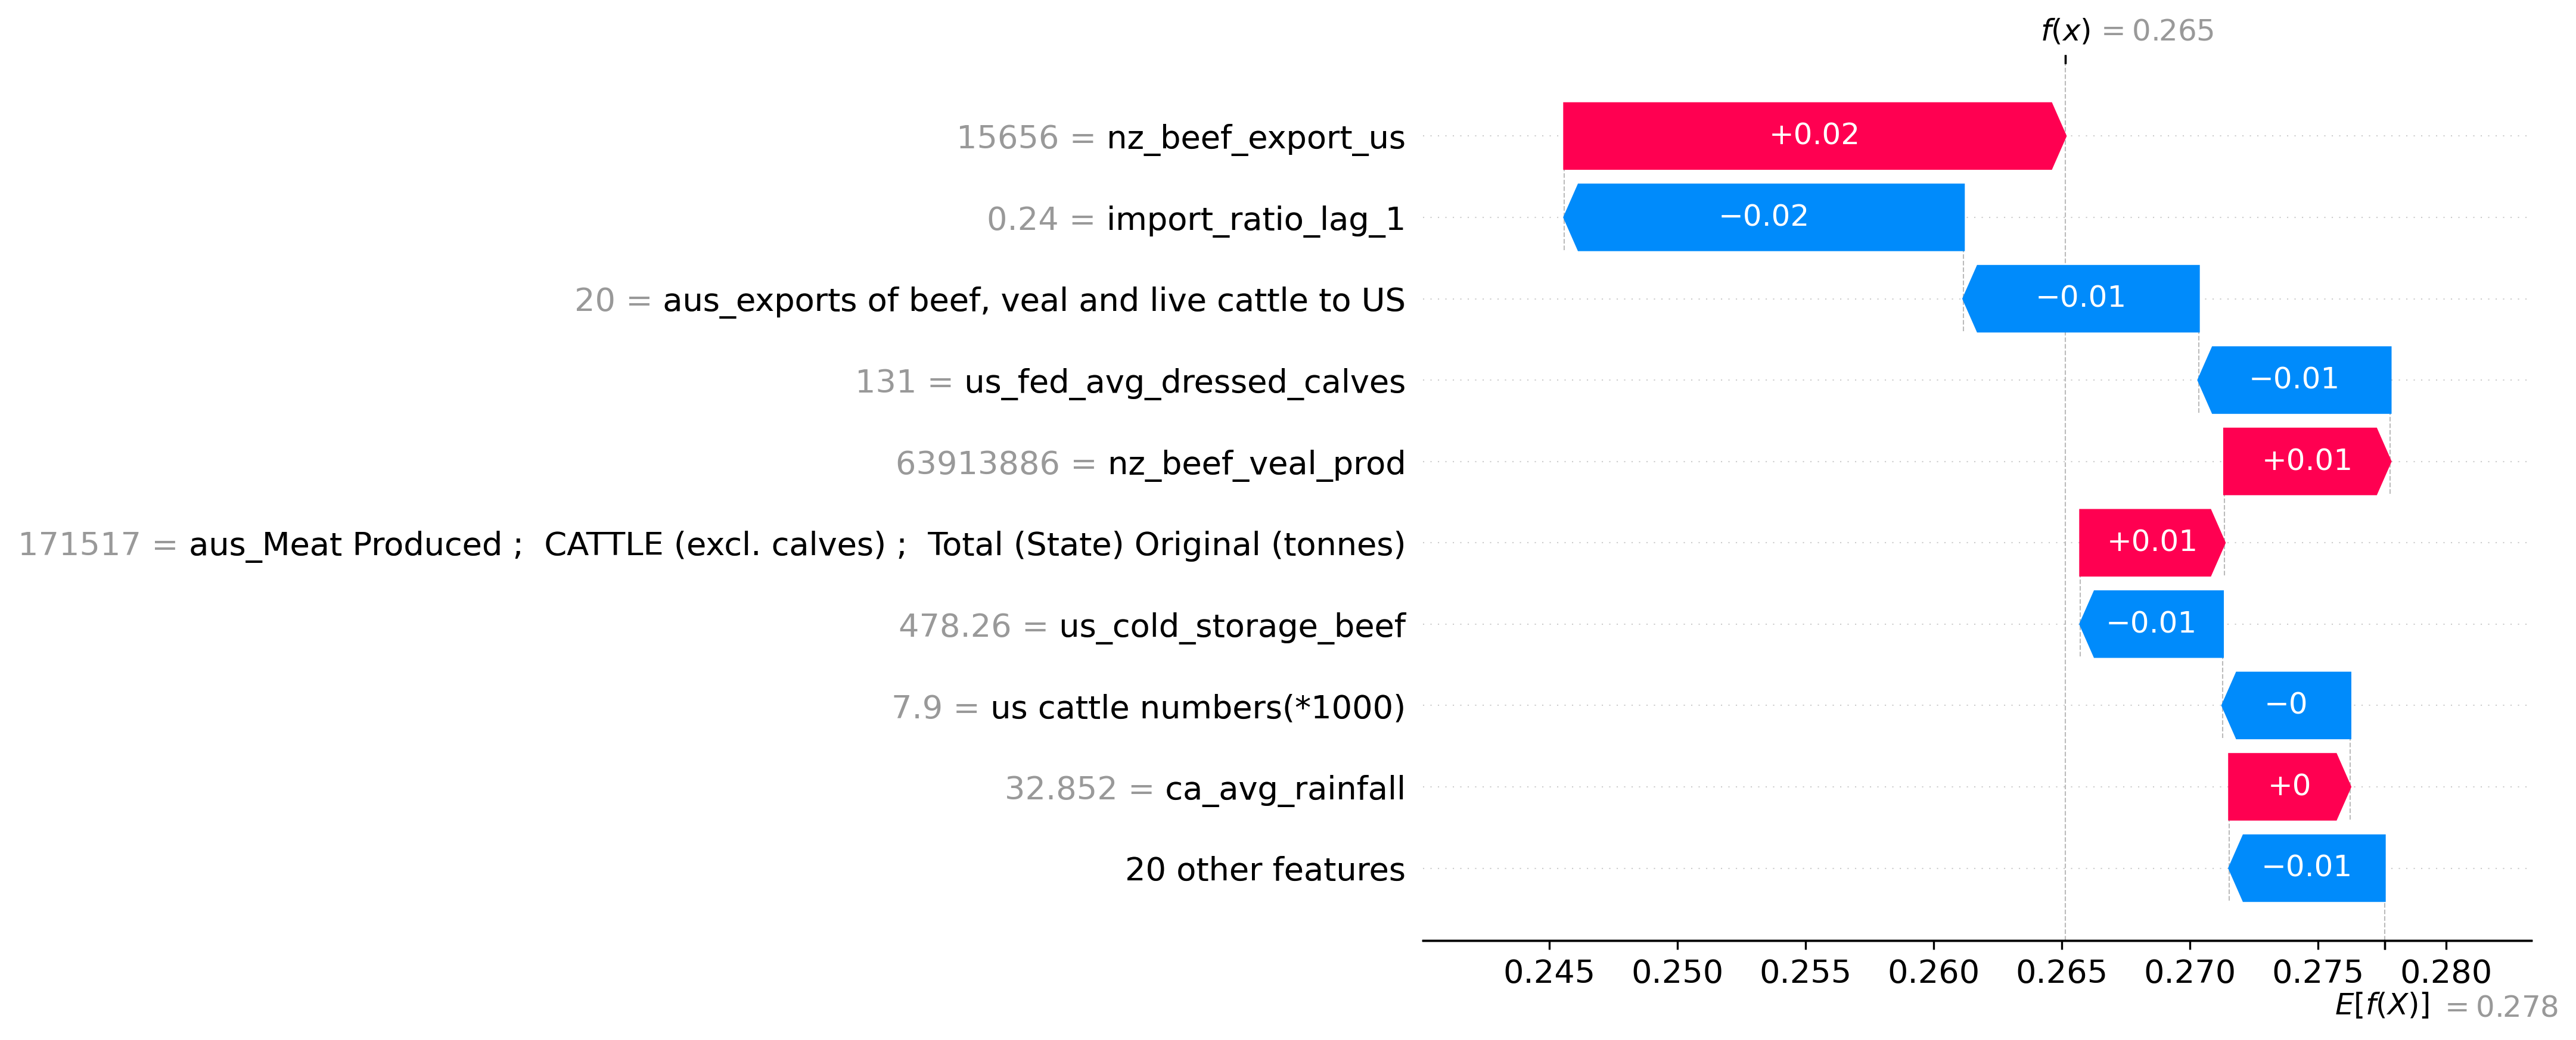

In [166]:
# visualize the first prediction's explanation
shap.plots.waterfall(shap_values_has_outlier[0])
#shap.plots.waterfall(shap_values_has_outlier[1])
#shap.plots.waterfall(shap_values_has_outlier[2])
#shap.plots.waterfall(shap_values_has_outlier[3])
shap.plots.waterfall(shap_values_has_outlier[4])
shap.plots.waterfall(shap_values_has_outlier[5])

In [167]:
# visualize a single(first) prediction's explanation with a force plot
shap.plots.force(shap_values_has_outlier[0])

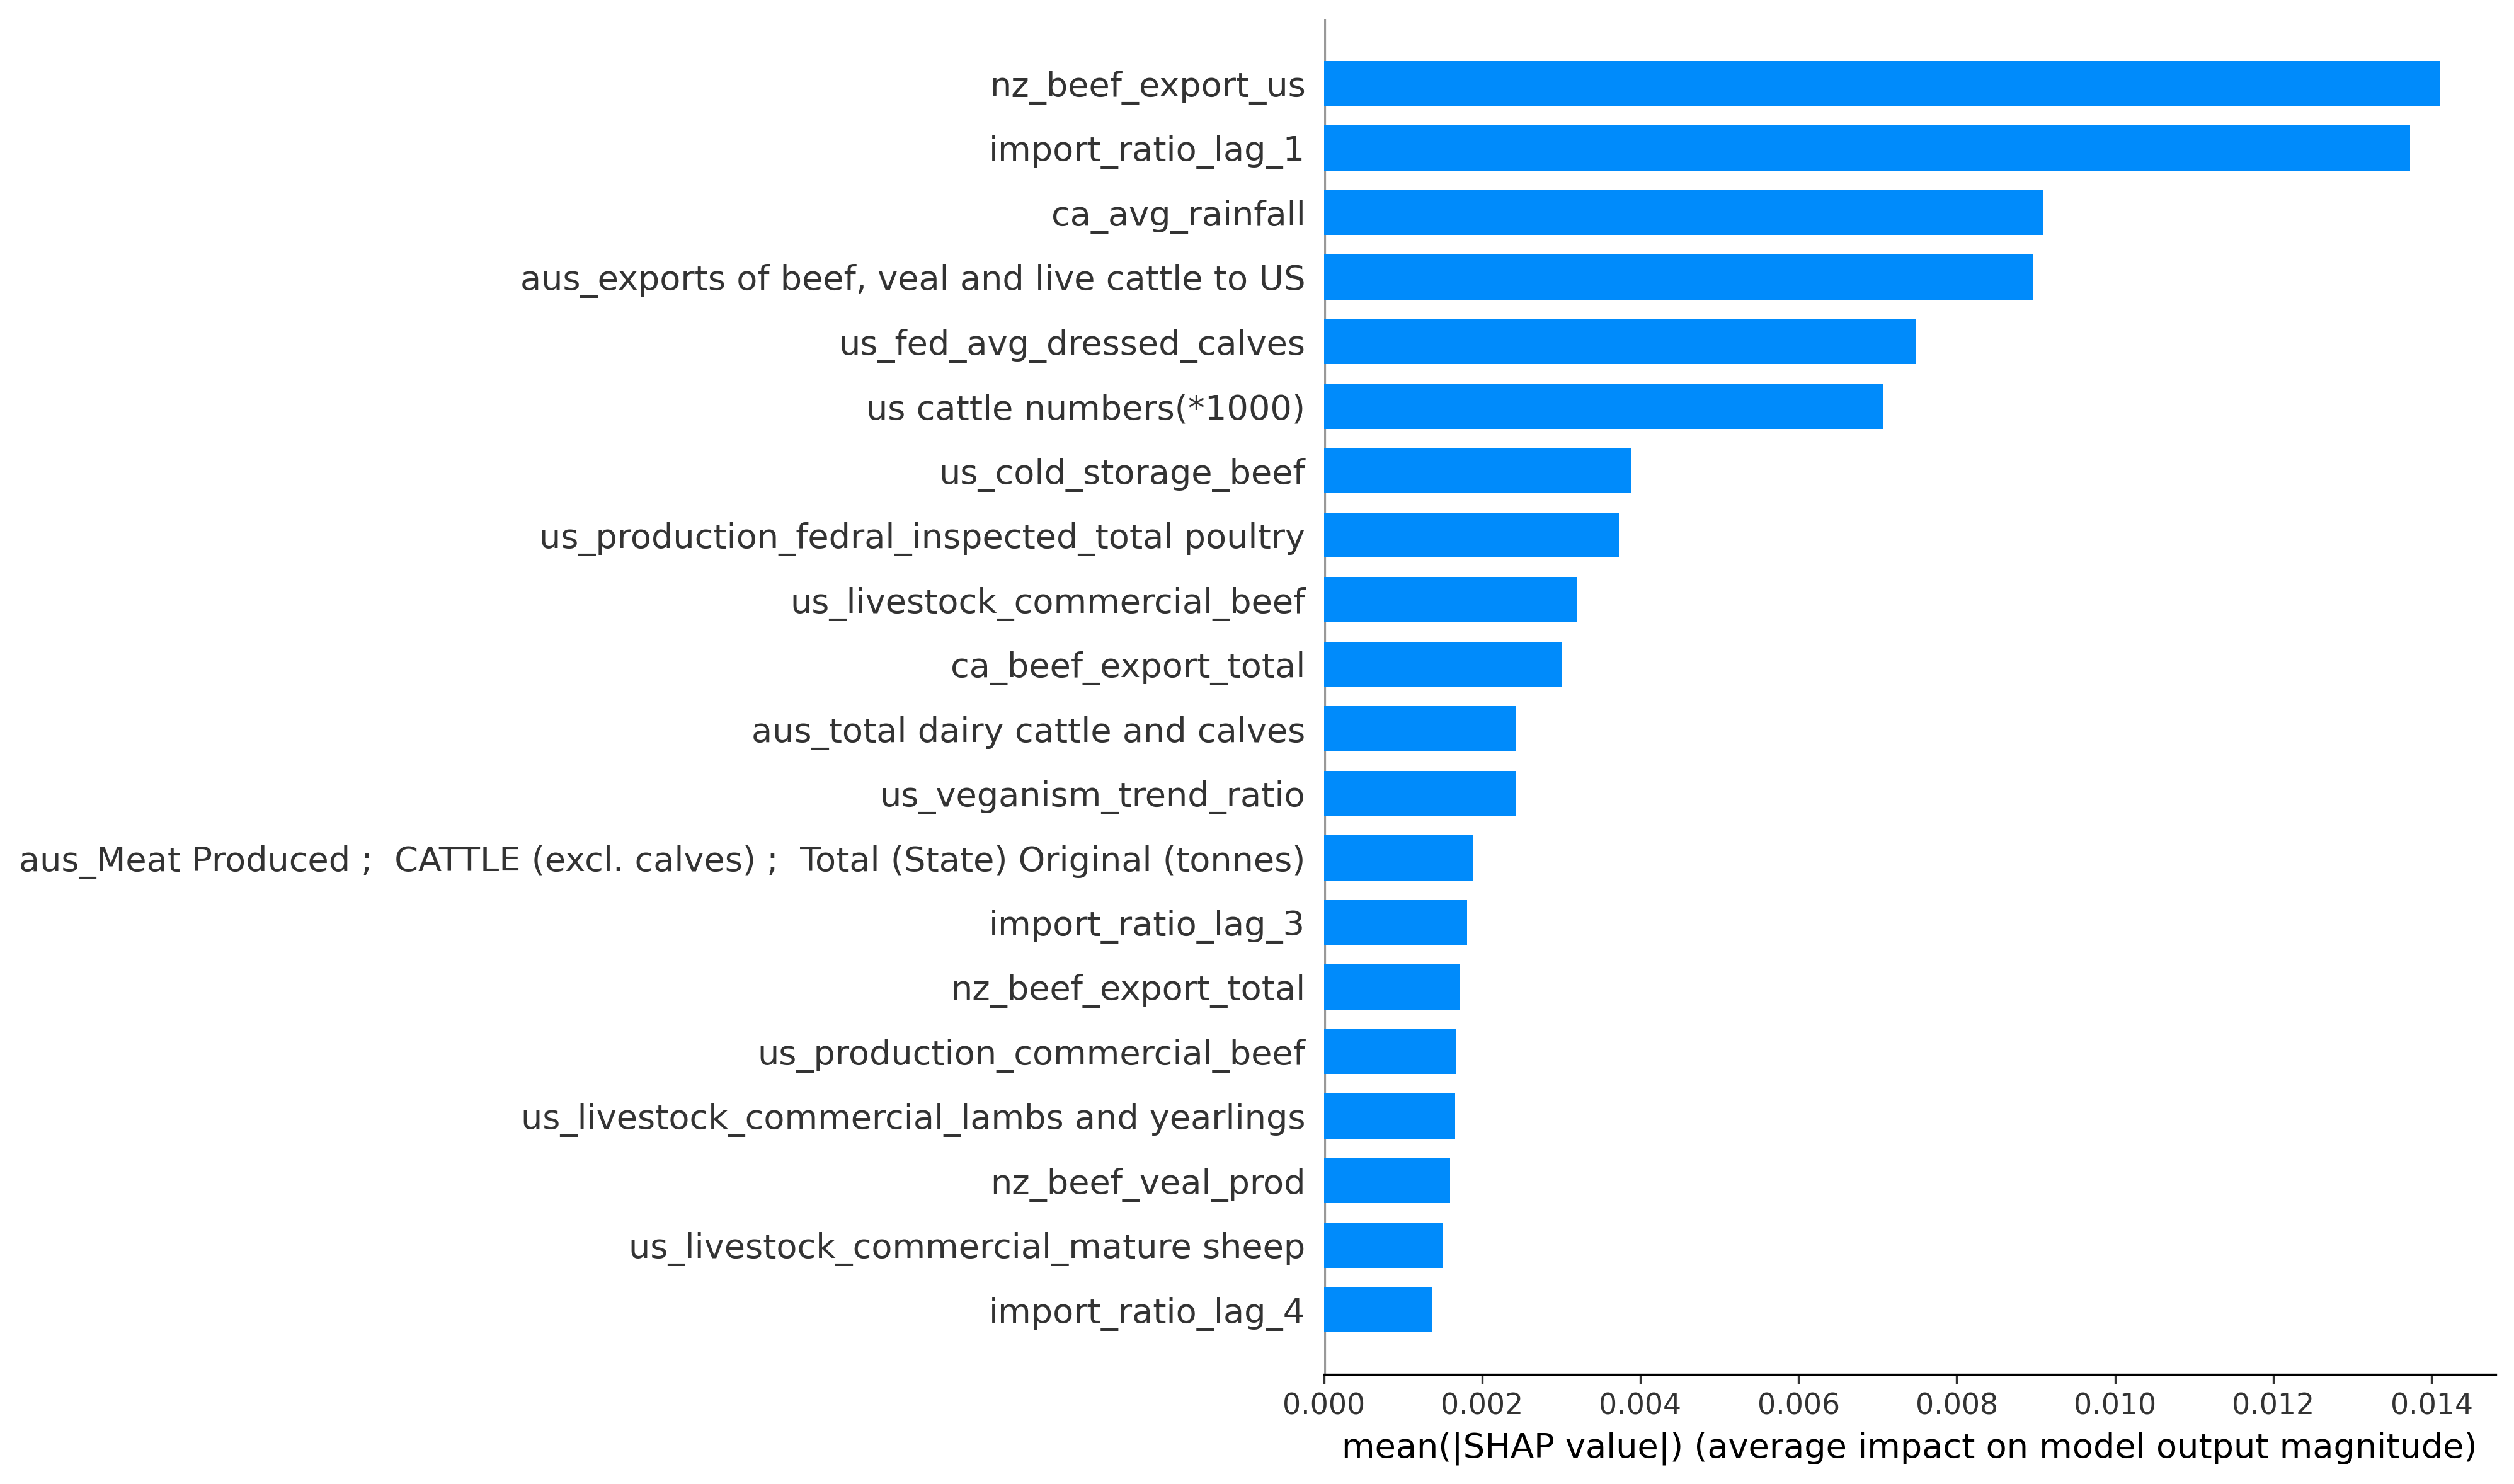

In [14]:
shap.summary_plot(shap_values_has_outlier, best_X_test_lag,plot_type="bar", show=False)
plt.savefig("6M_competitor_rank.pdf", format='pdf', dpi=1000, bbox_inches='tight')

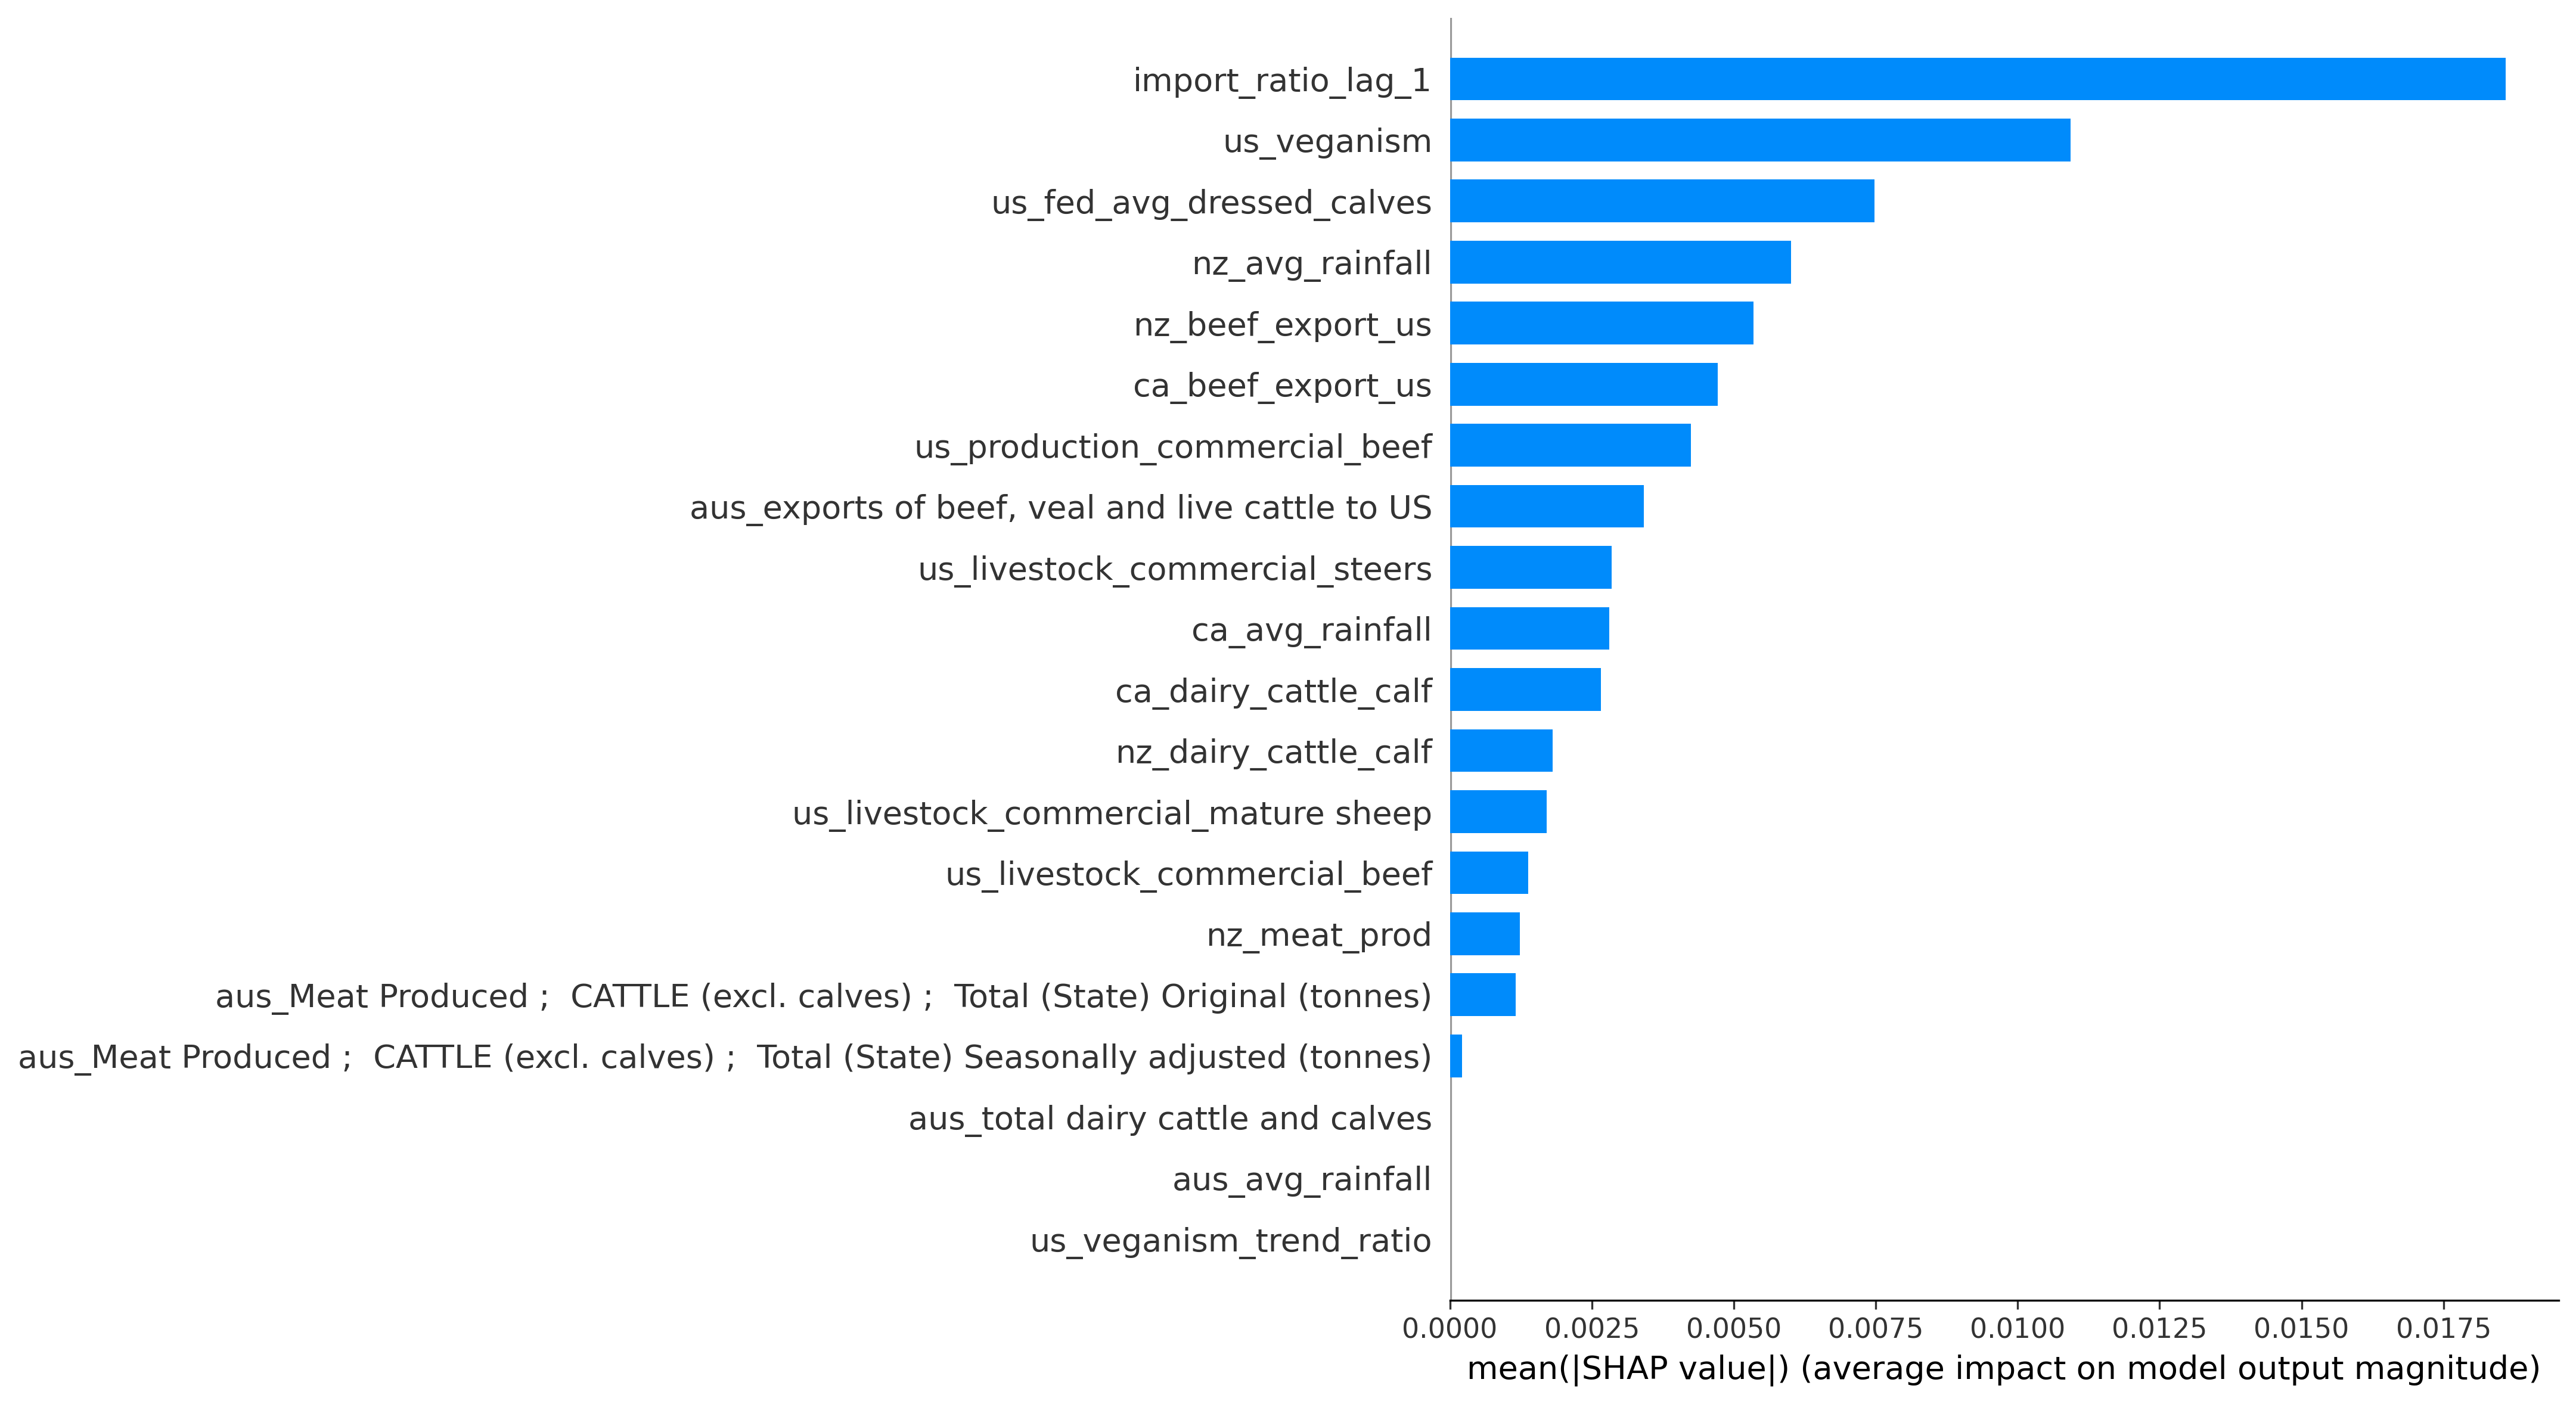

In [106]:
shap.summary_plot(shap_values_has_outlier, best_X_test_lag,plot_type="bar", show=False)
plt.savefig("6M_competitor_rank.pdf", format='pdf', dpi=1000, bbox_inches='tight')

In [33]:
def global_shap_importance(model, X):
    """ Return a dataframe containing the features sorted by Shap importance
    Parameters
    ----------
    model : The tree-based model 
    X : pd.Dataframe
         training set/test set/the whole dataset ... (without the label)
    Returns
    -------
    pd.Dataframe
        A dataframe containing the features sorted by Shap importance
    """
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    cohorts = {"": shap_values}
    cohort_labels = list(cohorts.keys())
    cohort_exps = list(cohorts.values())
    for i in range(len(cohort_exps)):
        if len(cohort_exps[i].shape) == 2:
            cohort_exps[i] = cohort_exps[i].abs.mean(0)
    features = cohort_exps[0].data
    feature_names = cohort_exps[0].feature_names
    values = np.array([cohort_exps[i].values for i in range(len(cohort_exps))])
    feature_importance = pd.DataFrame(
        list(zip(feature_names, sum(values))), columns=['features', 'importance'])
    feature_importance.sort_values(
        by=['importance'], ascending=False, inplace=True)
    return feature_importance

out1 = global_shap_importance(best_model, best_X_test_lag)
#out1.to_csv("old_12m_shap_rank.csv")
out1
#explainer_has_outlier = shap.TreeExplainer(best_model)
#shap_values_has_outlier = explainer_has_outlier(best_X_test_lag)

features  importance
24                                  nz_beef_export_us    0.014102
25                                 import_ratio_lag_1    0.013730
19                                    ca_avg_rainfall    0.009083
11    aus_exports of beef, veal and live cattle to US    0.008970
10                          us_fed_avg_dressed_calves    0.007481
9                            us cattle numbers(*1000)    0.007076
13                               us_cold_storage_beef    0.003878
12       us_production_fedral_inspected_total poultry    0.003728
2                        us_livestock_commercial_beef    0.003194
17                               ca_beef_export_total    0.003012
3                   aus_total dairy cattle and calves    0.002426
7                             us_veganism_trend_ratio    0.002423
4   aus_Meat Produced ;  CATTLE (excl. calves) ;  ...    0.001884
27                                 import_ratio_lag_3    0.001808
21                               nz_beef_export_total    0.001725
14                      us_production_commercial_beef    0.001668
0         us_livestock_commercial_lambs and yearlings    0.001656
22                                  nz_beef_veal_prod    0.001592
15               us_livestock_commercial_mature sheep    0.001503
28                                 import_ratio_lag_4    0.001369
8   aus_Meat Produced ;  CATTLE (excl. calves) ;  ...    0.001293
6                                    aus_avg_rainfall    0.001116
5                                         us_veganism    0.001025
26                                 import_ratio_lag_2    0.000748
1                               aus_beef&veal_exports    0.000705
16                     us_livestock_commercial_steers    0.000000
18                                  ca_beef_veal_prod    0.000000
20                                  ca_beef_export_us    0.000000
23                                    nz_avg_rainfall    0.000000